# H1-B Visa Petitions

Tong Li  

email: tong.li.21@alumni.ucl.ac.uk   
tel: +44 07732 145519

In [90]:
# data reading
import requests
from io import BytesIO
from zipfile import ZipFile
import re
from concurrent.futures import ThreadPoolExecutor

# data processing
import pandas as pd
import numpy as np
import datetime

# visualising
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# analysing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

In [7]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

## 1. Overall Summary

### 1.1 Data Source
The Office of Foreign Labor Certification (OFLC) generates data on visa programs including the H1-B visa.Here I use the 2016, 2015 and the 2014 datasets to process my analyse.

### 1.2 Steps
#### a. Reading Data from the US immigration department
1.Read the data (three options: a. Request data from the official website; b. Download the xlsx file to the local machine and read it directly; c. Compress the data into a zip file and then read it).  

2.Compare whether the column names of each dataframe are the same, and if so, merge the data into one dataframe. 

#### b. Cleaning Data
1. Check data quality using isnull() and duplicated().
2. Format the data using astype(), str.lower(), and str.upper().
3. Handle duplicate values using drop_duplicates().
4. Handle missing values using fillna() and dropna().
5. Handle outliers by identifying them using the quartile method.

#### c. Analysing Data
1. PETITION

    · Distribution across time;
    · Average processing time;
    · Geographic distribution

2. EMPLOYER     

    · Q1: Analyse the number of applications by employer (EMPLOYER_NAME), and find the top 10 employers with the most applications;
    
    · Analyse the geographic distribution of employers, and find the top 10 states with the most employers and the top three cities in each state;
    
    · Use choropleth map to show the distribution of data in each state; 
    
3. JOB

    · Analyse the number of job applications in SOC_NAME column and find the top 10 most applied job titles.  
    · What is the number of successful and failed applications for each job?
    
4. WAGE 

    · Distribution of wages
    · Q2: Is the applicant wage correlated with petition success?

#### d. Additional Analysis
1. After taking into account information such as occupation, work location, and employer, we then calculated the correlation between salary level and application success rate.

## 2. Data Poccessing

### 2.1 Read Data

If you don't want to download datasets into your local pc, please run the block below:

In [ ]:
# download dataset
url1 = "https://www.dol.gov/sites/dolgov/files/ETA/oflc/pdfs/H-1B_Disclosure_Data_FY16.xlsx"
url2 = "https://www.dol.gov/sites/dolgov/files/ETA/oflc/pdfs/H-1B_Disclosure_Data_FY15_Q4.xlsx"
url3 = "https://www.dol.gov/sites/dolgov/files/ETA/oflc/pdfs/H-1B_FY14_Q4.xlsx"

df16_raw = pd.read_excel(url1)
df15_raw = pd.read_excel(url2)
df14_raw = pd.read_excel(url3)

print("Dataset 1 shape:", df14_raw.shape)
print("Dataset 2 shape:", df15_raw.shape)
print("Dataset 3 shape:", df16_raw.shape)

Otherwise, you can download the three datasets locally and compress them into a zip file called raw_data.zip before reading them (which will be faster!)

In [8]:
# open .zip
with ZipFile('raw_data.zip', 'r') as zipfile:
    # read raw .xlsx files and store them 
    df14_raw = pd.read_excel(zipfile.open('H-1B_FY14_Q4.xlsx'))
    df15_raw = pd.read_excel(zipfile.open('H-1B_Disclosure_Data_FY15_Q4.xlsx'))
    df16_raw = pd.read_excel(zipfile.open('H-1B_Disclosure_Data_FY16.xlsx'))

### 2.2 Drop unnecessary columns

In [12]:
# merge columns
df15_raw['EMPLOYER_ADDRESS'] = df15_raw.apply(lambda x: f"{x['EMPLOYER_ADDRESS1']} {x['EMPLOYER_ADDRESS2']}" if pd.notnull(x['EMPLOYER_ADDRESS2']) else x['EMPLOYER_ADDRESS1'], axis=1)

# remove 'EMPLOYER_ADDRESS1' and 'EMPLOYER_ADDRESS2' columns
df15_raw.drop(['EMPLOYER_ADDRESS1', 'EMPLOYER_ADDRESS2'], axis=1, inplace=True)

df15_raw.head()

CASE_NUMBER CASE_STATUS CASE_SUBMITTED DECISION_DATE VISA_CLASS  \
0  I-200-09121-701936   WITHDRAWN     2015-02-05    2015-02-05       H-1B   
1  I-200-09146-796321   CERTIFIED     2014-12-12    2014-12-18       H-1B   
2  I-200-09180-329758   WITHDRAWN     2013-01-03    2014-12-15       H-1B   
3  I-200-09183-259985   CERTIFIED     2015-03-10    2015-03-16       H-1B   
4  I-200-09189-800933   CERTIFIED     2014-12-17    2014-12-23       H-1B   

  EMPLOYMENT_START_DATE EMPLOYMENT_END_DATE                    EMPLOYER_NAME  \
0            02/09/2015          02/28/2015                  MEDTRONIC, INC.   
1            01/05/2015          01/04/2018           UNIVERSITY OF OKLAHOMA   
2            01/07/2013          01/06/2016                       NOKIA INC.   
3            09/07/2015          09/07/2018  OMRON OILFIELD AND MARINE, INC.   
4            06/06/2015          06/05/2018   FEDERAL HOME LOAN MORTGAGE CO.   

  EMPLOYER_CITY EMPLOYER_STATE EMPLOYER_POSTAL_CODE          EMPLOYER_COUNTRY  \
0   MINNEAPOLIS             MN                55432  UNITED STATES OF AMERICA   
1        NORMAN             OK                73019  UNITED STATES OF AMERICA   
2        IRVING             TX                75039  UNITED STATES OF AMERICA   
3       HOUSTON             TX                77088  UNITED STATES OF AMERICA   
4        MCLEAN             VA                22102  UNITED STATES OF AMERICA   

  EMPLOYER_PROVINCE  EMPLOYER_PHONE  EMPLOYER_PHONE_EXT AGENT_ATTORNEY_NAME  \
0               NaN   7635052710.00                 NaN     DEBRA SCHNEIDER   
1               NaN   4053251826.00                 NaN                 NaN   
2               NaN   9728945000.00                 NaN         HASEENA ENU   
3               NaN   7138491700.00                 NaN        ELDON KAKUDA   
4               NaN   7039188838.00                 NaN     JAMES ALEXANDER   

  AGENT_ATTORNEY_CITY AGENT_ATTORNEY_STATE                          JOB_TITLE  \
0         MINNEAPOLIS                   MN                MECHANICAL ENGINEER   
1                 NaN                  NaN                ASSISTANT PROFESSOR   
2              DALLAS                   TX  RELEASE AND SOFTWARE TEST MANAGER   
3          SCHAUMBURG                   IL     CONTROL ENGINEERING SPECIALIST   
4          WASHINGTON                   DC                 DEVELOPMENT SENIOR   

     SOC_CODE                                SOC_NAME  NAIC_CODE  \
0  17-2141.00                    MECHANICAL ENGINEERS  334510.00   
1     25-1032     ENGINEERING TEACHERS, POSTSECONDARY  611310.00   
2     15-1799        COMPUTER OCCUPATIONS, ALL OTHER*  517212.00   
3     17-2072  ELECTRONICS ENGINEERS, EXCEPT COMPUTER  335314.00   
4     15-1131                    COMPUTER PROGRAMMERS  522294.00   

   TOTAL WORKERS FULL_TIME_POSITION  PREVAILING_WAGE PW_UNIT_OF_PAY  \
0           1.00                  Y         19000.00           Year   
1           1.00                  Y         42860.00           Year   
2           1.00                  Y         73965.00           Year   
3           2.00                  Y         65998.00           Year   
4           1.00                  Y         96907.00           Year   

  PW_WAGE_LEVEL PW_WAGE_SOURCE  PW_WAGE_SOURCE_YEAR     PW_WAGE_SOURCE_OTHER  \
0       Level I            OES              2014.00       ONLINE DATA SURVEY   
1       Level I          Other              2014.00  OFLC ONLINE DATA CENTER   
2      Level II            OES              2012.00  OFLC ONLINE DATA CENTER   
3       Level I            OES              2014.00  OFLC ONLINE DATA CENTER   
4      Level IV            OES              2014.00  OFLC ONLINE DATA CENTER   

  WAGE_RATE_OF_PAY WAGE_UNIT_OF_PAY H-1B_DEPENDENT WILLFUL VIOLATOR  \
0          20000 -             Year              N                N   
1       85000.00 -             Year              N                N   
2          94000 -             Year              N                N   
3    66000 - 700

### 2.3 Clean Column Names 

In [13]:
datasets = [df14_raw, df15_raw, df16_raw]

for i, dataset in enumerate(datasets):
    print(f"columns' name of dataframe {i + 1} ：")
    print(dataset.columns)
    print("\n")

columns' name of dataframe 1 ：
Index(['LCA_CASE_NUMBER', 'STATUS', 'LCA_CASE_SUBMIT', 'DECISION_DATE',
       'VISA_CLASS', 'LCA_CASE_EMPLOYMENT_START_DATE',
       'LCA_CASE_EMPLOYMENT_END_DATE', 'LCA_CASE_EMPLOYER_NAME',
       'LCA_CASE_EMPLOYER_ADDRESS', 'LCA_CASE_EMPLOYER_CITY',
       'LCA_CASE_EMPLOYER_STATE', 'LCA_CASE_EMPLOYER_POSTAL_CODE',
       'LCA_CASE_SOC_CODE', 'LCA_CASE_SOC_NAME', 'LCA_CASE_JOB_TITLE',
       'LCA_CASE_WAGE_RATE_FROM', 'LCA_CASE_WAGE_RATE_TO',
       'LCA_CASE_WAGE_RATE_UNIT', 'FULL_TIME_POS', 'TOTAL_WORKERS',
       'LCA_CASE_WORKLOC1_CITY', 'LCA_CASE_WORKLOC1_STATE', 'PW_1',
       'PW_UNIT_1', 'PW_SOURCE_1', 'OTHER_WAGE_SOURCE_1', 'YR_SOURCE_PUB_1',
       'LCA_CASE_WORKLOC2_CITY', 'LCA_CASE_WORKLOC2_STATE', 'PW_2',
       'PW_UNIT_2', 'PW_SOURCE_2', 'OTHER_WAGE_SOURCE_2', 'YR_SOURCE_PUB_2',
       'LCA_CASE_NAICS_CODE'],
      dtype='object')


columns' name of dataframe 2 ：
Index(['CASE_NUMBER', 'CASE_STATUS', 'CASE_SUBMITTED', 'DECISION_DATE',
  

In [14]:
# Mapping different column names to the same standard column name
column_name_mapping = {
    'LCA_CASE_NUMBER': 'CASE_NUMBER',
    'LCA_CASE_SUBMIT': 'CASE_SUBMITTED',
    'STATUS': 'CASE_STATUS',
    'LCA_CASE_EMPLOYMENT_START_DATE': 'EMPLOYMENT_START_DATE',
    'LCA_CASE_EMPLOYMENT_END_DATE': 'EMPLOYMENT_END_DATE',
    'LCA_CASE_EMPLOYER_NAME': 'EMPLOYER_NAME',
    'LCA_CASE_EMPLOYER_ADDRESS': 'EMPLOYER_ADDRESS',
    'LCA_CASE_EMPLOYER_CITY': 'EMPLOYER_CITY',
    'LCA_CASE_EMPLOYER_STATE': 'EMPLOYER_STATE',
    'LCA_CASE_EMPLOYER_POSTAL_CODE': 'EMPLOYER_POSTAL_CODE',
    'LCA_CASE_SOC_CODE': 'SOC_CODE',
    'LCA_CASE_SOC_NAME': 'SOC_NAME',
    'LCA_CASE_JOB_TITLE': 'JOB_TITLE',
    'LCA_CASE_WAGE_RATE_FROM': 'WAGE_RATE_OF_PAY_FROM',
    'LCA_CASE_WAGE_RATE_TO': 'WAGE_RATE_OF_PAY_TO',
    'LCA_CASE_WAGE_RATE_UNIT': 'WAGE_UNIT_OF_PAY',
    'FULL_TIME_POS': 'FULL_TIME_POSITION',
    'TOTAL_WORKERS': 'TOTAL_WORKERS',
    'LCA_CASE_WORKLOC1_CITY': 'WORKSITE_CITY',
    'LCA_CASE_WORKLOC1_STATE': 'WORKSITE_STATE',
    'PW_1': 'PREVAILING_WAGE',
    'PW_UNIT_1': 'PW_UNIT_OF_PAY',
    'PW_SOURCE_1': 'PW_WAGE_SOURCE',
    'OTHER_WAGE_SOURCE_1': 'PW_SOURCE_OTHER',
    'YR_SOURCE_PUB_1': 'PW_SOURCE_YEAR',
    'LCA_CASE_NAICS_CODE': 'NAIC_CODE',
}

In [15]:
# Rename the column names using the mapping dictionary to make the column names consistent across the three datasets
df14 = df14_raw.rename(columns=column_name_mapping)
df15 = df15_raw.rename(columns=column_name_mapping)
df16 = df16_raw.rename(columns=column_name_mapping)

In [16]:
columns_df14 = set(df14.columns)
columns_df15 = set(df15.columns)
columns_df16 = set(df16.columns)

unique_df14 = columns_df14.difference(columns_df15).difference(columns_df16)
unique_df15 = columns_df15.difference(columns_df14).difference(columns_df16)
unique_df16 = columns_df16.difference(columns_df14).difference(columns_df15)

print("columns only in df14：", unique_df14)
print("columns only in df15：", unique_df15)
print("columns only in df16：", unique_df16)

columns only in df14： {'PW_2', 'PW_UNIT_2', 'YR_SOURCE_PUB_2', 'OTHER_WAGE_SOURCE_2', 'LCA_CASE_WORKLOC2_CITY', 'PW_SOURCE_2', 'LCA_CASE_WORKLOC2_STATE'}
columns only in df15： {'PW_WAGE_LEVEL', 'TOTAL WORKERS', 'WILLFUL VIOLATOR', 'WAGE_RATE_OF_PAY', 'PW_WAGE_SOURCE_OTHER', 'PW_WAGE_SOURCE_YEAR'}
columns only in df16： {'WILLFUL_VIOLATOR', 'ORIGINAL_CERT_DATE'}


### 2.4 Merge Data

In [17]:
merged_data = pd.concat([df14, df15, df16], axis=0, ignore_index=True, join="outer")

In [18]:
merged_data.head()

CASE_NUMBER          CASE_STATUS      CASE_SUBMITTED  \
0  I-200-09106-546545  CERTIFIED-WITHDRAWN 2013-01-18 18:05:43   
1  I-200-09162-143337            CERTIFIED 2014-03-17 11:11:45   
2  I-200-09182-550211               DENIED 2014-03-14 17:05:01   
3  I-200-09193-873099            CERTIFIED 2014-03-01 12:37:02   
4  I-200-09197-120609  CERTIFIED-WITHDRAWN 2014-03-10 15:33:41   

        DECISION_DATE VISA_CLASS EMPLOYMENT_START_DATE  EMPLOYMENT_END_DATE  \
0 2014-09-29 15:59:50       H-1B   2013-02-01 00:00:00  2016-02-01 00:00:00   
1 2014-03-21 23:11:51       H-1B   2014-09-15 00:00:00  2017-09-15 00:00:00   
2 2014-03-20 16:59:49       H-1B   2014-04-01 00:00:00  2015-04-01 00:00:00   
3 2014-03-06 22:03:37       H-1B   2014-08-28 00:00:00  2017-08-27 00:00:00   
4 2014-03-17 10:52:46       H-1B   2014-09-01 00:00:00  2017-09-01 00:00:00   

                       EMPLOYER_NAME           EMPLOYER_ADDRESS  \
0  TEXAS STATE UNIVERSITY-SAN MARCOS       601 UNIVERSITY DRIVE   
1   EYE SPECIALISTS OF INDIANA, P.C.       1901 N. MERIDIAN ST.   
2                          LHB, INC.    21 WEST SUPERIOR STREET   
3                      WAM USA, INC.     75 BOULDERBROOK CIRCLE   
4           DFUSE TECHNOLOGIES, INC.  20143 DESERT FOREST DRIVE   

   EMPLOYER_CITY EMPLOYER_STATE EMPLOYER_POSTAL_CODE SOC_CODE  \
0     SAN MARCOS             TX                78666  19-1029   
1   INDIANAPOLIS             IN                46202  29-1041   
2         DULUTH             MN                55802  27-2011   
3  LAWRENCEVILLE             GA                30045  13-2011   
4        ASHBURN             VA                20147  15-1131   

                           SOC_NAME                        JOB_TITLE  \
0  Biological Scientists, All Other  POSTDOCTORAL RESEARCH ASSOCIATE   
1                      Optometrists                      OPTOMETRIST   
2                            Actors            FOOD SAFETY SCIENTIST   
3          Accountants and Auditors         INTERNATIONAL ACCOUNTANT   
4              Computer Programmers               PROGRAMMER ANALYST   

   WAGE_RATE_OF_PAY_FROM  WAGE_RATE_OF_PAY_TO WAGE_UNIT_OF_PAY  \
0               50000.00             60000.00             Year   
1               65000.00                  NaN             Year   
2               50000.00                  NaN             Year   
3               48000.00                  NaN             Year   
4               62000.00                  NaN             Year   

  FULL_TIME_POSITION  TOTAL_WORKERS  WORKSITE_CITY WORKSITE_STATE  \
0                  Y           1.00     SAN MARCOS             TX   
1                  Y           1.00   INDIANAPOLIS             IN   
2                  Y           1.00           FARG             WI   
3                  Y           1.00  LAWRENCEVILLE             GA   
4                  Y           1.00       SAN JOSE             CA   

   PREVAILING_WAGE PW_UNIT_OF_PAY PW_WAGE_SOURCE          PW_SOURCE_OTHER  \
0         43118.00           Year            OES  OFLC ONLINE DATA CENTER   
1         64251.00           Year          Other  OFLC ONLINE DATA CENTER   
2         50000.00           Year            OES             OFLIC ONLINE   
3         47424.00           Year          Other  OFLC ONLINE DATA CENTER   
4         61589.00           Year            OES  OFLC ONLINE DATA CENTER   

   PW_SOURCE_YEAR LCA_CASE_WORKLOC2_CITY LCA_CASE_WORKLOC2_STATE     PW_2  \
0         2013.00              ST. LOUIS                      MO 49566.00   
1         2013.00           INDIANAPOLIS                      IN 64251.00   
2         2014.00                    NaN                     NaN      NaN   
3         2014.00                    NaN                     NaN      NaN   
4         2013.00                    NaN                     NaN      NaN   

  PW_UNIT_2 PW_SOURCE_2      OTHER_WAGE_SOURCE_2          YR_SOURCE_PUB_2  \
0      Year         OES  OFLC ONLINE DATA CENTER  OFLC ONLINE DATA CENTER   
1      Year       O

In [19]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1786160 entries, 0 to 1786159
Data columns (total 53 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   CASE_NUMBER              object        
 1   CASE_STATUS              object        
 2   CASE_SUBMITTED           datetime64[ns]
 3   DECISION_DATE            datetime64[ns]
 4   VISA_CLASS               object        
 5   EMPLOYMENT_START_DATE    object        
 6   EMPLOYMENT_END_DATE      object        
 7   EMPLOYER_NAME            object        
 8   EMPLOYER_ADDRESS         object        
 9   EMPLOYER_CITY            object        
 10  EMPLOYER_STATE           object        
 11  EMPLOYER_POSTAL_CODE     object        
 12  SOC_CODE                 object        
 13  SOC_NAME                 object        
 14  JOB_TITLE                object        
 15  WAGE_RATE_OF_PAY_FROM    float64       
 16  WAGE_RATE_OF_PAY_TO      float64       
 17  WAGE_UNIT_OF_PAY         ob

### 2.5 Tidying

In [20]:
# choose 1000 rows randomly for running code quickly
#df_sample = merged_data.sample(n=100000)
#df_sample.head()

df_sample = merged_data
df_sample.head()

CASE_NUMBER          CASE_STATUS      CASE_SUBMITTED  \
0  I-200-09106-546545  CERTIFIED-WITHDRAWN 2013-01-18 18:05:43   
1  I-200-09162-143337            CERTIFIED 2014-03-17 11:11:45   
2  I-200-09182-550211               DENIED 2014-03-14 17:05:01   
3  I-200-09193-873099            CERTIFIED 2014-03-01 12:37:02   
4  I-200-09197-120609  CERTIFIED-WITHDRAWN 2014-03-10 15:33:41   

        DECISION_DATE VISA_CLASS EMPLOYMENT_START_DATE  EMPLOYMENT_END_DATE  \
0 2014-09-29 15:59:50       H-1B   2013-02-01 00:00:00  2016-02-01 00:00:00   
1 2014-03-21 23:11:51       H-1B   2014-09-15 00:00:00  2017-09-15 00:00:00   
2 2014-03-20 16:59:49       H-1B   2014-04-01 00:00:00  2015-04-01 00:00:00   
3 2014-03-06 22:03:37       H-1B   2014-08-28 00:00:00  2017-08-27 00:00:00   
4 2014-03-17 10:52:46       H-1B   2014-09-01 00:00:00  2017-09-01 00:00:00   

                       EMPLOYER_NAME           EMPLOYER_ADDRESS  \
0  TEXAS STATE UNIVERSITY-SAN MARCOS       601 UNIVERSITY DRIVE   
1   EYE SPECIALISTS OF INDIANA, P.C.       1901 N. MERIDIAN ST.   
2                          LHB, INC.    21 WEST SUPERIOR STREET   
3                      WAM USA, INC.     75 BOULDERBROOK CIRCLE   
4           DFUSE TECHNOLOGIES, INC.  20143 DESERT FOREST DRIVE   

   EMPLOYER_CITY EMPLOYER_STATE EMPLOYER_POSTAL_CODE SOC_CODE  \
0     SAN MARCOS             TX                78666  19-1029   
1   INDIANAPOLIS             IN                46202  29-1041   
2         DULUTH             MN                55802  27-2011   
3  LAWRENCEVILLE             GA                30045  13-2011   
4        ASHBURN             VA                20147  15-1131   

                           SOC_NAME                        JOB_TITLE  \
0  Biological Scientists, All Other  POSTDOCTORAL RESEARCH ASSOCIATE   
1                      Optometrists                      OPTOMETRIST   
2                            Actors            FOOD SAFETY SCIENTIST   
3          Accountants and Auditors         INTERNATIONAL ACCOUNTANT   
4              Computer Programmers               PROGRAMMER ANALYST   

   WAGE_RATE_OF_PAY_FROM  WAGE_RATE_OF_PAY_TO WAGE_UNIT_OF_PAY  \
0               50000.00             60000.00             Year   
1               65000.00                  NaN             Year   
2               50000.00                  NaN             Year   
3               48000.00                  NaN             Year   
4               62000.00                  NaN             Year   

  FULL_TIME_POSITION  TOTAL_WORKERS  WORKSITE_CITY WORKSITE_STATE  \
0                  Y           1.00     SAN MARCOS             TX   
1                  Y           1.00   INDIANAPOLIS             IN   
2                  Y           1.00           FARG             WI   
3                  Y           1.00  LAWRENCEVILLE             GA   
4                  Y           1.00       SAN JOSE             CA   

   PREVAILING_WAGE PW_UNIT_OF_PAY PW_WAGE_SOURCE          PW_SOURCE_OTHER  \
0         43118.00           Year            OES  OFLC ONLINE DATA CENTER   
1         64251.00           Year          Other  OFLC ONLINE DATA CENTER   
2         50000.00           Year            OES             OFLIC ONLINE   
3         47424.00           Year          Other  OFLC ONLINE DATA CENTER   
4         61589.00           Year            OES  OFLC ONLINE DATA CENTER   

   PW_SOURCE_YEAR LCA_CASE_WORKLOC2_CITY LCA_CASE_WORKLOC2_STATE     PW_2  \
0         2013.00              ST. LOUIS                      MO 49566.00   
1         2013.00           INDIANAPOLIS                      IN 64251.00   
2         2014.00                    NaN                     NaN      NaN   
3         2014.00                    NaN                     NaN      NaN   
4         2013.00                    NaN                     NaN      NaN   

  PW_UNIT_2 PW_SOURCE_2      OTHER_WAGE_SOURCE_2          YR_SOURCE_PUB_2  \
0      Year         OES  OFLC ONLINE DATA CENTER  OFLC ONLINE DATA CENTER   
1      Year       O

#### 2.5.1 Strings to lowercase letters

In [21]:
df_sample.columns = [col.lower() for col in df_sample.columns]

for column in df_sample.columns:
    if df_sample[column].dtype == 'object':
        df_sample[column] = df_sample[column].str.lower()

#### 2.5.2 remove duplications

In [22]:
duplicate_rows = df_sample.duplicated()
print(duplicate_rows)

0          False
1          False
2          False
3          False
4          False
           ...  
1786155    False
1786156    False
1786157    False
1786158    False
1786159    False
Length: 1786160, dtype: bool


In [23]:
df_sample = df_sample.drop_duplicates()
#df_sample.info()

#### 2.5.3 deal with missing data

· fill in missing values

    The data point 0 in wage_rate_of_pay_to should mean no upper limit, replace with NA.

· remove non-essential columns 

    Columns with 2 in the column name;
    Columns whose column names begin with agent_;
    employer_province, employer_phone, employer_phone_ext

In [24]:
missing_values = df_sample.isnull().sum()
print(missing_values)

case_number                      0
case_status                      0
case_submitted                   0
decision_date                    0
visa_class                       0
employment_start_date      1167375
employment_end_date        1167375
employer_name                   66
employer_address                69
employer_city                   64
employer_state                 123
employer_postal_code           100
soc_code                        72
soc_name                      4295
job_title                       34
wage_rate_of_pay_from       618838
wage_rate_of_pay_to        1035375
wage_unit_of_pay                76
full_time_position          647870
total_workers               618805
worksite_city                  102
worksite_state                  86
prevailing_wage                152
pw_unit_of_pay                 203
pw_wage_source                 207
pw_source_other             638402
pw_source_year              618947
lca_case_workloc2_city     1702270
lca_case_workloc2_st

##### a. Fill missing values
The data point 0 in wage_rate_of_pay_to should mean uncapped and be replaced by NA;

In [25]:
df_sample['wage_rate_of_pay_to'] = df_sample['wage_rate_of_pay_to'].replace(0, np.nan)

C:\Users\StevenYang\AppData\Local\Temp\ipykernel_54740\1137791649.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['wage_rate_of_pay_to'] = df_sample['wage_rate_of_pay_to'].replace(0, np.nan)


##### b. remove non-essential columns

In [26]:
# Columns with 2 and agent_ in the column name
columns_to_drop = [col for col in df_sample.columns if '2' in col or 'agent' in col]

columns_to_drop.extend(['employer_province', 'employer_phone', 'employer_phone_ext'])

df_sample = df_sample.drop(columns_to_drop, axis=1)

#### 2.5.4 deal with missing data in wages

##### a. column 'wage_rate_of_pay'

For values in this column that are not NA, perform the following:

    1. remove error values：    
    
        · Digits larger than eight digits (may be a wrongly filled in phone number)   
        · Repeated numbers, e.g. 23.622362   
        
    2. Modify the number format:      
    
        · num1 - num2: calculate the average wages   
        · num - : remove "-" then convert them into float or int

In [29]:
def process_wage_and_return_original(row):
    value = row['wage_rate_of_pay']
    if pd.isna(value) or value.strip() == '-':
        return None, None

    # dealing with values countaining "-"
    pattern = r'(\d+(?:\.\d{1,2})?)(?:\s?-\s?(\d+(?:\.\d{1,2})?))?'
    match = re.match(pattern, value)
    if match:
        num1 = float(match.group(1))
        num2 = match.group(2)
        if num2:
            num2 = float(num2)
            return value, (num1 + num2) / 2
        return value, num1

    # dealing with repeat numbers
    str_value = str(value)
    if len(str_value) > 7:
        processed_value = float(str_value[:str_value.find(str_value[4:])])
        return value, processed_value

    # remove values that digits larger than eight digits 
    if len(str(value)) >= 8:
        return value, None

    return value, float(value)

In [30]:
temp_df = df_sample.apply(process_wage_and_return_original, axis=1, result_type='expand')
temp_df.columns = ['original_wage', 'calculated_wage']

#checking processed values to make sure every error value has been dealt with
df_sample = pd.concat([df_sample, temp_df], axis=1)
processed_rows = df_sample[df_sample['wage_rate_of_pay'] != df_sample['calculated_wage']]

print(processed_rows[['wage_rate_of_pay','calculated_wage']])

        wage_rate_of_pay  calculated_wage
0                    NaN              NaN
1                    NaN              NaN
2                    NaN              NaN
3                    NaN              NaN
4                    NaN              NaN
...                  ...              ...
1786155              NaN              NaN
1786156              NaN              NaN
1786157              NaN              NaN
1786158              NaN              NaN
1786159              NaN              NaN

[1786158 rows x 2 columns]


In [31]:
print(df_sample['calculated_wage'].describe())

count        618783.00
mean         168270.69
std        69918802.05
min               0.00
25%           60070.00
50%           72254.00
75%           95000.00
max     55000106500.00
Name: calculated_wage, dtype: float64


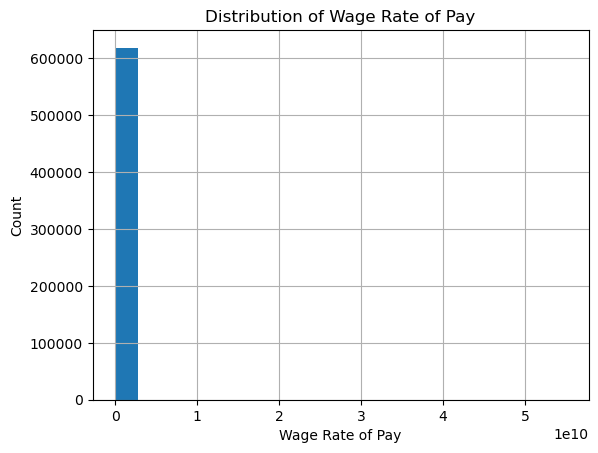

In [32]:
# bar plot
df_sample['calculated_wage'].hist(bins=20)
plt.title('Distribution of Wage Rate of Pay')
plt.xlabel('Wage Rate of Pay')
plt.ylabel('Count')
plt.show()

##### b. fill in missing values in wages
    b.1. Calculate the average of [wage_rate_of_pay_from] and [wage_rate_of_pay_to] as the salary of the applicant when both are not NA;
    
    b.2. If only [wage_rate_of_pay_from] is available, use that as the salary;
    
    b.3. If both [wage_rate_of_pay_from] and [wage_rate_of_pay_to] are NA, use [prevailing_wage] as the salary of the applicant;

    * It is necessary to distinguish by [pw_unit_of_pay] (year or hour).

In [33]:
def fill_calculated_wage(row):
    if pd.isna(row['calculated_wage']):
        if not pd.isna(row['wage_rate_of_pay_from']) and not pd.isna(row['wage_rate_of_pay_to']):
            row['calculated_wage'] = (row['wage_rate_of_pay_from'] + row['wage_rate_of_pay_to']) / 2
        elif not pd.isna(row['wage_rate_of_pay_from']) and pd.isna(row['wage_rate_of_pay_to']):
            row['calculated_wage'] = row['wage_rate_of_pay_from']
        elif pd.isna(row['wage_rate_of_pay_from']) and pd.isna(row['wage_rate_of_pay_to']):
            row['calculated_wage'] = row['prevailing_wage']
    return row

df_sample = df_sample.apply(fill_calculated_wage, axis=1)

##### c. checking errors and outliers in wages

In [34]:
df_hourly = df_sample[df_sample['wage_unit_of_pay'] == 'hour']
df_yearly = df_sample[df_sample['wage_unit_of_pay'] == 'year']

In [35]:
print(df_hourly['calculated_wage'].describe())

count     114400.00
mean         388.35
std        30559.22
min            0.00
25%           25.29
50%           31.72
75%           41.16
max     10186389.00
Name: calculated_wage, dtype: float64


In [36]:
print(df_yearly['calculated_wage'].describe())

count       1668506.00
mean         123727.17
std        42956176.88
min               0.00
25%           63000.00
50%           75000.00
75%           98688.75
max     55000106500.00
Name: calculated_wage, dtype: float64


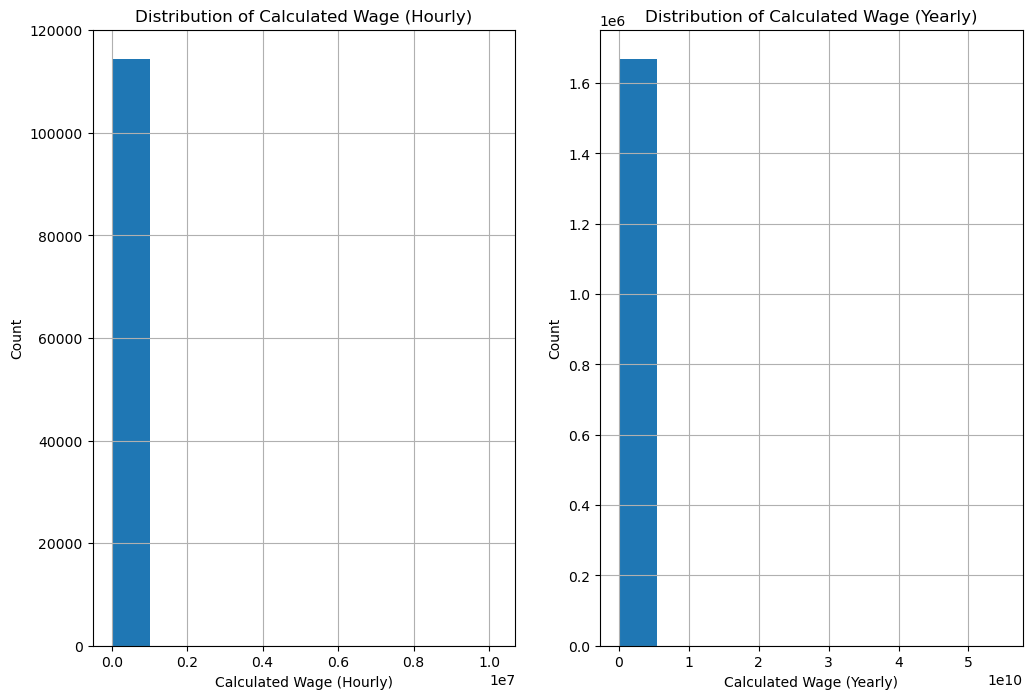

In [37]:
# bar plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
df_hourly['calculated_wage'].hist(ax=axes[0])
axes[0].set_title('Distribution of Calculated Wage (Hourly)')
axes[0].set_xlabel('Calculated Wage (Hourly)')
axes[0].set_ylabel('Count')
df_yearly['calculated_wage'].hist(ax=axes[1])
axes[1].set_title('Distribution of Calculated Wage (Yearly)')
axes[1].set_xlabel('Calculated Wage (Yearly)')
axes[1].set_ylabel('Count')
plt.show()

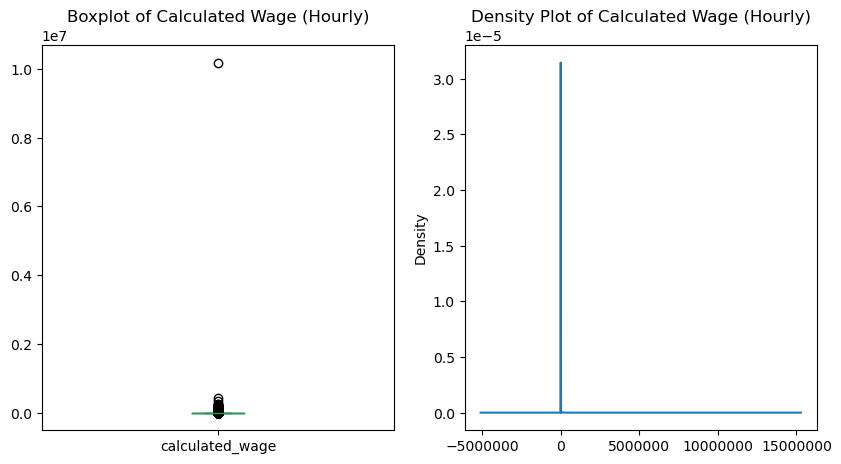

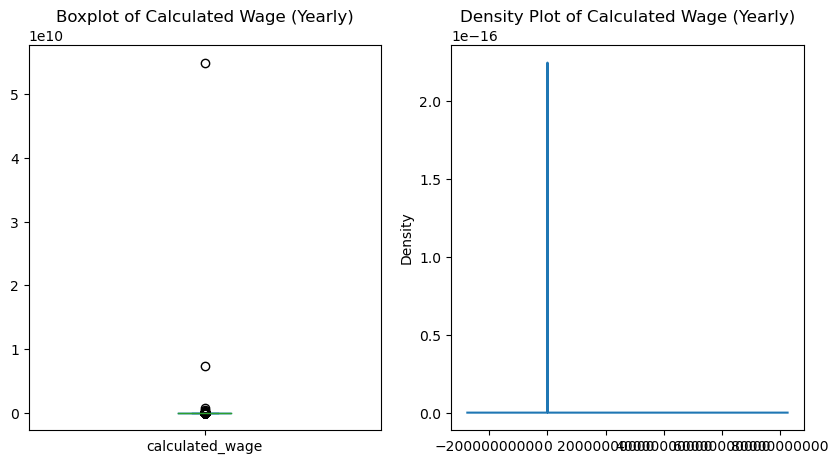

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
df_hourly['calculated_wage'].plot(kind='box', ax=axes[0])
axes[0].set_title('Boxplot of Calculated Wage (Hourly)')
df_hourly['calculated_wage'].plot(kind='density', ax=axes[1])
axes[1].set_title('Density Plot of Calculated Wage (Hourly)')
axes[1].ticklabel_format(style='plain', axis='x')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
df_yearly['calculated_wage'].plot(kind='box', ax=axes[0])
axes[0].set_title('Boxplot of Calculated Wage (Yearly)')
df_yearly['calculated_wage'].plot(kind='density', ax=axes[1])
axes[1].set_title('Density Plot of Calculated Wage (Yearly)')
axes[1].ticklabel_format(style='plain', axis='x')
plt.show()

##### d. remove errors and outliers

In [43]:
# hourly wages
# remove outlier
q75_hourly= df_hourly['calculated_wage'].quantile(q=0.75)

# values lager than q75
outliers_hourly = df_hourly[df_hourly['calculated_wage'] > q75_hourly]

print(outliers_hourly['calculated_wage'].sort_values(ascending=False).head(20))

67854     10186389.00
267885      437840.52
310985      328885.00
1018697     250000.00
13302       238358.50
1772037     230971.00
1766294     225000.00
1766289     225000.00
393522      220000.00
390827      220000.00
145625      220000.00
23702       200000.00
223455      200000.00
761016      195000.00
958632      170000.00
9358        168000.00
514986      165000.00
94036       159352.72
319593      150000.00
518310      136000.00
Name: calculated_wage, dtype: float64


In [42]:
# yearly wages
# remove outlier
q75_yearly= df_yearly['calculated_wage'].quantile(q=0.75)

# values lager than q75
outliers_yearly = df_yearly[df_yearly['calculated_wage'] > q75_yearly]

print(outliers_yearly['calculated_wage'].sort_values(ascending=False).head(20))

1034745   55000106500.00
498763     7278872788.00
418267      750000200.00
388759      437000472.00
357188      201313899.00
721641       44099802.00
1128091      19000000.00
513363       13900000.00
799256       11700023.00
81495        11145203.00
840556       11000000.00
66864        10186389.00
339882        9700002.00
513354        9500000.00
421532        9063912.00
475832        8650720.00
61986         8288000.00
88559         8000000.00
244255        7734194.00
99345         7267273.00
Name: calculated_wage, dtype: float64


In [44]:
# run this block unless you find outliers
# find the row with error value
row_to_drop = outliers_yearly[outliers_yearly['calculated_wage'] > 1000000].index.union(
    outliers_hourly[outliers_hourly['calculated_wage'] > 130000].index)

# remove it
df_sample = df_sample.drop(row_to_drop)

In [45]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1786057 entries, 0 to 1786159
Data columns (total 42 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   case_number            object        
 1   case_status            object        
 2   case_submitted         datetime64[ns]
 3   decision_date          datetime64[ns]
 4   visa_class             object        
 5   employment_start_date  object        
 6   employment_end_date    object        
 7   employer_name          object        
 8   employer_address       object        
 9   employer_city          object        
 10  employer_state         object        
 11  employer_postal_code   object        
 12  soc_code               object        
 13  soc_name               object        
 14  job_title              object        
 15  wage_rate_of_pay_from  float64       
 16  wage_rate_of_pay_to    float64       
 17  wage_unit_of_pay       object        
 18  full_time_position    

In [46]:
df_sample.dropna(subset=['calculated_wage'], inplace=True)

In [47]:
#checking missing values again
missing_values = df_sample.isnull().sum()
print(missing_values)

case_number                    0
case_status                    0
case_submitted                 0
decision_date                  0
visa_class                     0
employment_start_date    1167247
employment_end_date      1167247
employer_name                 33
employer_address              35
employer_city                 30
employer_state                90
employer_postal_code          66
soc_code                      57
soc_name                    4280
job_title                     18
wage_rate_of_pay_from     618767
wage_rate_of_pay_to      1544818
wage_unit_of_pay              28
full_time_position        647840
total_workers             618765
worksite_city                 54
worksite_state                38
prevailing_wage              103
pw_unit_of_pay               155
pw_wage_source               163
pw_source_other           638333
pw_source_year            618878
naic_code                     17
employer_country          519415
total workers            1167244
pw_wage_le

#### 2.5.5 common units of measurement

##### a. Calculating cases processing time and length of employment
    · case_processing_time (days) = decision_date - case_submitted  
    · employment_length (days) = employment_end_date - employment_start_date  

In [49]:
df_sample['decision_date'] = pd.to_datetime(df_sample['decision_date'], errors='coerce')
df_sample['case_submitted'] = pd.to_datetime(df_sample['case_submitted'], errors='coerce')
df_sample['case_processing_time'] = df_sample['decision_date'] - df_sample['case_submitted']

df_sample['employment_end_date'] = pd.to_datetime(df_sample['employment_end_date'], errors='coerce')
df_sample['employment_start_date'] = pd.to_datetime(df_sample['employment_start_date'], errors='coerce')
df_sample['employment_length'] = df_sample['employment_end_date'] - df_sample['employment_start_date']

df_sample.head()

C:\Users\StevenYang\AppData\Local\Temp\ipykernel_54740\29738175.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_sample['employment_start_date'] = pd.to_datetime(df_sample['employment_start_date'], errors='coerce')


case_number          case_status      case_submitted  \
0  i-200-09106-546545  certified-withdrawn 2013-01-18 18:05:43   
1  i-200-09162-143337            certified 2014-03-17 11:11:45   
2  i-200-09182-550211               denied 2014-03-14 17:05:01   
3  i-200-09193-873099            certified 2014-03-01 12:37:02   
4  i-200-09197-120609  certified-withdrawn 2014-03-10 15:33:41   

        decision_date visa_class employment_start_date employment_end_date  \
0 2014-09-29 15:59:50       h-1b                   NaT                 NaT   
1 2014-03-21 23:11:51       h-1b                   NaT                 NaT   
2 2014-03-20 16:59:49       h-1b                   NaT                 NaT   
3 2014-03-06 22:03:37       h-1b                   NaT                 NaT   
4 2014-03-17 10:52:46       h-1b                   NaT                 NaT   

                       employer_name           employer_address  \
0  texas state university-san marcos       601 university drive   
1   eye specialists of indiana, p.c.       1901 n. meridian st.   
2                          lhb, inc.    21 west superior street   
3                      wam usa, inc.     75 boulderbrook circle   
4           dfuse technologies, inc.  20143 desert forest drive   

   employer_city employer_state employer_postal_code soc_code  \
0     san marcos             tx                78666  19-1029   
1   indianapolis             in                46202  29-1041   
2         duluth             mn                55802  27-2011   
3  lawrenceville             ga                30045  13-2011   
4        ashburn             va                20147  15-1131   

                           soc_name                        job_title  \
0  biological scientists, all other  postdoctoral research associate   
1                      optometrists                      optometrist   
2                            actors            food safety scientist   
3          accountants and auditors         international accountant   
4              computer programmers               programmer analyst   

   wage_rate_of_pay_from  wage_rate_of_pay_to wage_unit_of_pay  \
0               50000.00             60000.00             year   
1               65000.00                  NaN             year   
2               50000.00                  NaN             year   
3               48000.00                  NaN             year   
4               62000.00                  NaN             year   

  full_time_position  total_workers  worksite_city worksite_state  \
0                  y           1.00     san marcos             tx   
1                  y           1.00   indianapolis             in   
2                  y           1.00           farg             wi   
3                  y           1.00  lawrenceville             ga   
4                  y           1.00       san jose             ca   

   prevailing_wage pw_unit_of_pay pw_wage_source          pw_source_other  \
0         43118.00           year            oes  oflc online data center   
1         64251.00           year          other  oflc online data center   
2         50000.00           year            oes             oflic online   
3         47424.00           year          other  oflc online data center   
4         61589.00           year            oes  oflc online data center   

   pw_source_year  naic_code employer_country  total workers pw_wage_level  \
0         2013.00  611310.00              NaN            NaN           NaN   
1         2013.00  621320.00              NaN            NaN           NaN   
2         2014.00  541330.00              NaN            NaN           NaN   
3         2014.00  333922.00              NaN            NaN           NaN   
4         2013.00  541519.00              NaN            NaN           NaN   

   pw_wage_source_year pw_wage_source_other wage_rate_of_pay h-1b_dependent  \
0                  NaN                  NaN              NaN            NaN   
1              

In [50]:
print(df_sample['case_processing_time'].describe())

count                        1786007
mean      32 days 19:00:22.444916508
std      130 days 09:48:43.598293070
min                  0 days 00:00:00
25%                  6 days 00:00:00
50%                  6 days 00:00:00
75%           6 days 18:39:30.500000
max               2367 days 00:00:00
Name: case_processing_time, dtype: object


In [51]:
print(df_sample['employment_length'].describe())

count                          618758
mean     1042 days 04:01:28.621399664
std       169 days 00:43:35.315351332
min              -1848 days +00:00:00
25%                1095 days 00:00:00
50%                1095 days 00:00:00
75%                1095 days 00:00:00
max                1460 days 00:00:00
Name: employment_length, dtype: object


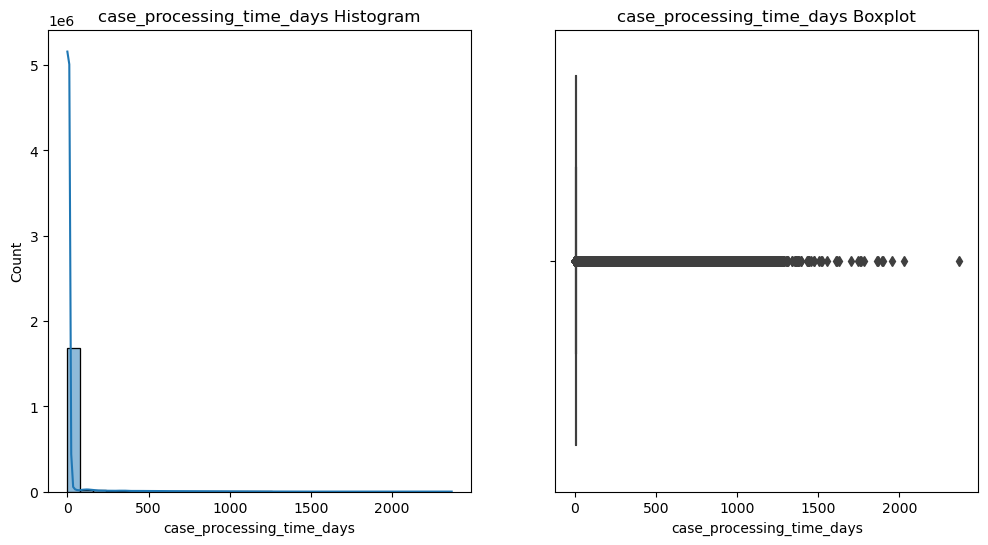

In [52]:
df_sample['case_processing_time_days'] = pd.to_datetime(df_sample['case_processing_time'], errors='coerce')

df_sample['case_processing_time_days'] = df_sample['case_processing_time'].dt.days


continuous_columns = ['case_processing_time_days']

for column in continuous_columns:
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(data=df_sample, x=column, kde=True, bins=30)
    plt.title(f"{column} Histogram")
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df_sample, x=column)
    plt.title(f"{column} Boxplot")
    
    plt.show()

## 3. Data Analysis

Before we start the analysis, there're some extra columns need to be added. Here they are:

First we need a column to store the results that whether a case is successful.

In [53]:
df_sample['successful_petition'] = np.where(df_sample['case_status'].isin(['certified', 'certified-withdrawn']), 1, 0)

Then we also need another column to restore the case results by string: successful or failed.

In [54]:
df_sample['case_outcome'] = df_sample['case_status'].apply(lambda x: 'successful' if x in ['certified', 'certified-withdrawn'] else 'failed')

We also need two new columns to additionally store the year and month of the case submission date.

In [67]:
# Extract year
df_sample['year'] = pd.to_datetime(df_sample['case_submitted']).dt.year
df_yearly['year'] = pd.to_datetime(df_yearly['case_submitted']).dt.year
df_hourly['year'] = pd.to_datetime(df_hourly['case_submitted']).dt.year

# Extract month
df_sample['month'] = pd.to_datetime(df_sample['case_submitted']).dt.month

### 3.1 Petitions

#### 3.1.1 Distribution of petitions across time

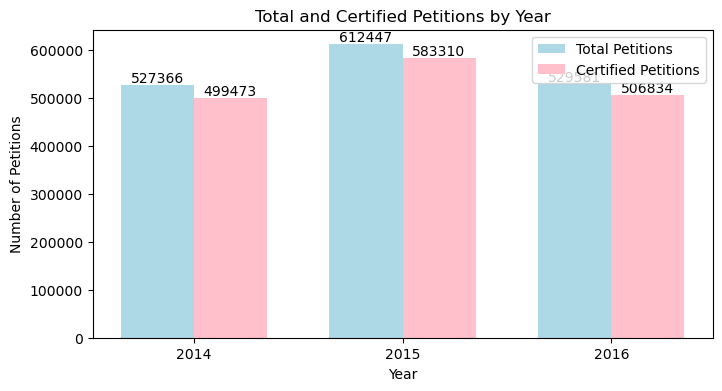

In [56]:
years = [2014, 2015, 2016]
yearly_data = df_sample[df_sample['year'].isin(years)].groupby('year', as_index=False).agg(
    {'successful_petition': 'sum', 'case_number': 'count'}
)

yearly_data['year'] = yearly_data['year'].astype(str)

# plotting bar charts
fig, ax = plt.subplots(figsize=(8, 4))
x = np.arange(len(years))
bar_width = 0.35

ax.bar(x - bar_width / 2, yearly_data['case_number'], bar_width, label="Total Petitions", color='lightblue')
ax.bar(x + bar_width / 2, yearly_data['successful_petition'], bar_width, label="Certified Petitions", color='pink')

# add numbers under bars
for i, row in yearly_data.iterrows():
    ax.text(i - bar_width / 2, row['case_number'], row['case_number'], ha='center', va='bottom')
    ax.text(i + bar_width / 2, row['successful_petition'], row['successful_petition'], ha='center', va='bottom')

ax.set_xlabel("Year")
ax.set_ylabel("Number of Petitions")
ax.set_title("Total and Certified Petitions by Year")
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.legend()

plt.show()

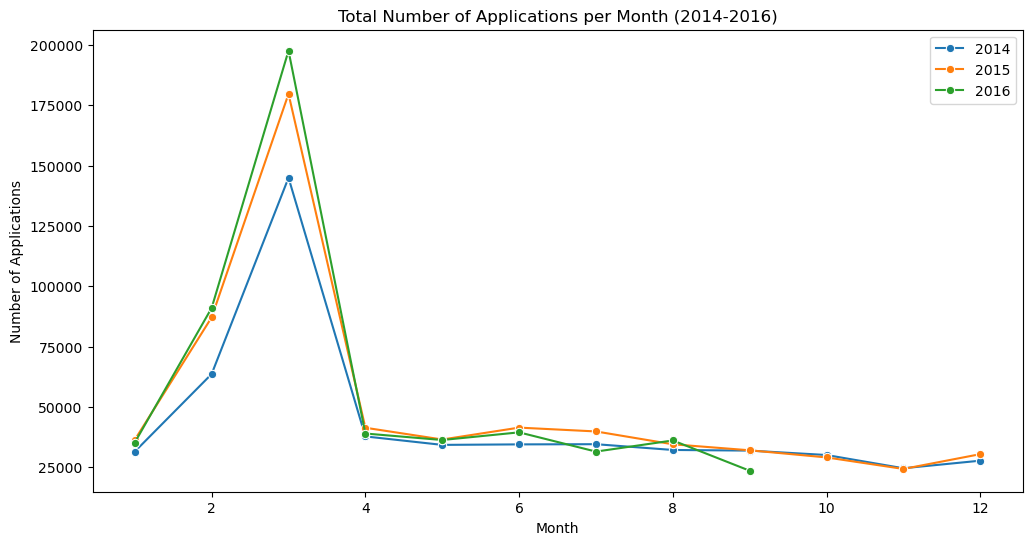

In [57]:
# select year
selected_years_data = df_sample[df_sample['year'].isin([2014, 2015, 2016])]

# calculate count of cases by months
monthly_data = selected_years_data.groupby(['year', 'month'], as_index=False)['case_number'].count()

# plotting line charts
plt.figure(figsize=(12, 6))

sns.lineplot(data=monthly_data[monthly_data['year'] == 2014], x='month', y='case_number', marker='o', label='2014')
sns.lineplot(data=monthly_data[monthly_data['year'] == 2015], x='month', y='case_number', marker='o', label='2015')
sns.lineplot(data=monthly_data[monthly_data['year'] == 2016], x='month', y='case_number', marker='o', label='2016')

plt.xlabel('Month')
plt.ylabel('Number of Applications')
plt.title('Total Number of Applications per Month (2014-2016)')
plt.legend()
plt.show()

H-1B申请数量在每年三月特别多的原因与美国移民局（USCIS）的H-1B配额和申请流程有关。H-1B签证有一个每年的配额限制，目前是65,000个名额，另外还有20,000个名额专门为美国硕士学位或更高学位的申请人设置。这些名额按照财政年度分配，财政年度从每年的10月1日开始。

美国移民局规定，企业最早可以在开始日期的六个月前提交H-1B申请。因此，对于以财政年度开始日期为准的H-1B申请，企业可以从每年的4月1日开始提交申请。通常，这个日期一到，许多雇主都会立即提交大量H-1B申请，以确保在名额用尽之前为员工获得签证。实际上，H-1B名额通常在短短几天内就被抢光。这就是为什么每年三月份的H-1B申请数量会特别多的原因。

#### 3.1.2 Average processing time of petitions

In [58]:
df_filtered = df_sample[(df_sample['year'] >= 2014) & (df_sample['year'] <= 2016)]

grouped_describe = df_filtered.groupby('case_outcome')['case_processing_time_days'].describe()
print(grouped_describe)

                  count  mean    std  min  25%  50%  75%    max
case_outcome                                                   
failed         79777.00 26.75 108.46 0.00 0.00 3.00 6.00 995.00
successful   1589617.00 16.22  63.14 0.00 6.00 6.00 6.00 996.00


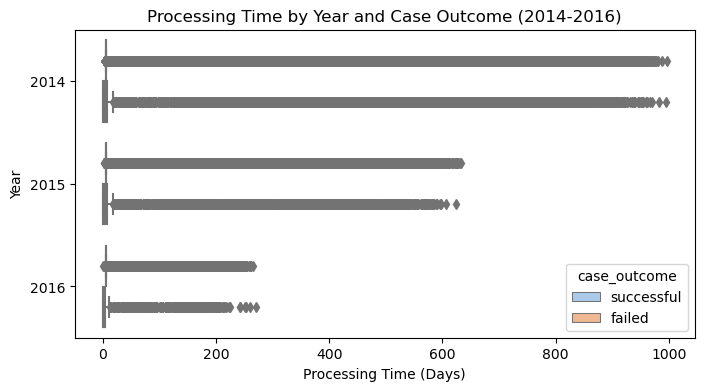

In [59]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_filtered, x='case_processing_time_days', y='year', hue='case_outcome', palette='pastel', orient='h')
plt.xlabel("Processing Time (Days)")
plt.ylabel("Year")
plt.title("Processing Time by Year and Case Outcome (2014-2016)")
plt.show()

To better observe the results, we can log case_processing_time_days:

C:\Users\StevenYang\AppData\Local\Temp\ipykernel_54740\3379456839.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['log_case_processing_time_days'] = np.log10(df_filtered['case_processing_time_days'] + 1)


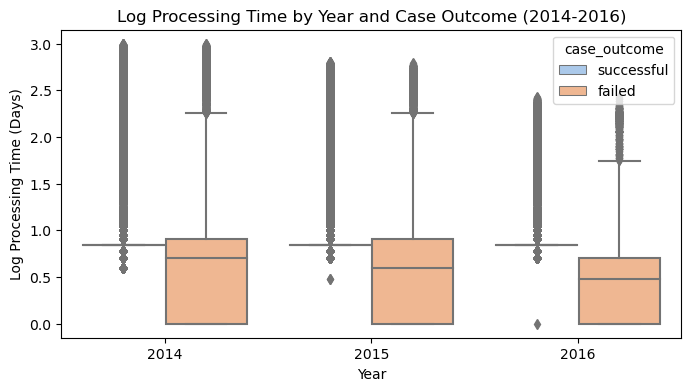

In [60]:
# log case_processing_time_days 
df_filtered['log_case_processing_time_days'] = np.log10(df_filtered['case_processing_time_days'] + 1)

# plotting box-plot
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_filtered, x='year', y='log_case_processing_time_days', hue='case_outcome', palette='pastel')
plt.xlabel("Year")
plt.ylabel("Log Processing Time (Days)")
plt.title("Log Processing Time by Year and Case Outcome (2014-2016)")
plt.show()

结果：

#### 3.1.3 Geographic distribution of petitions

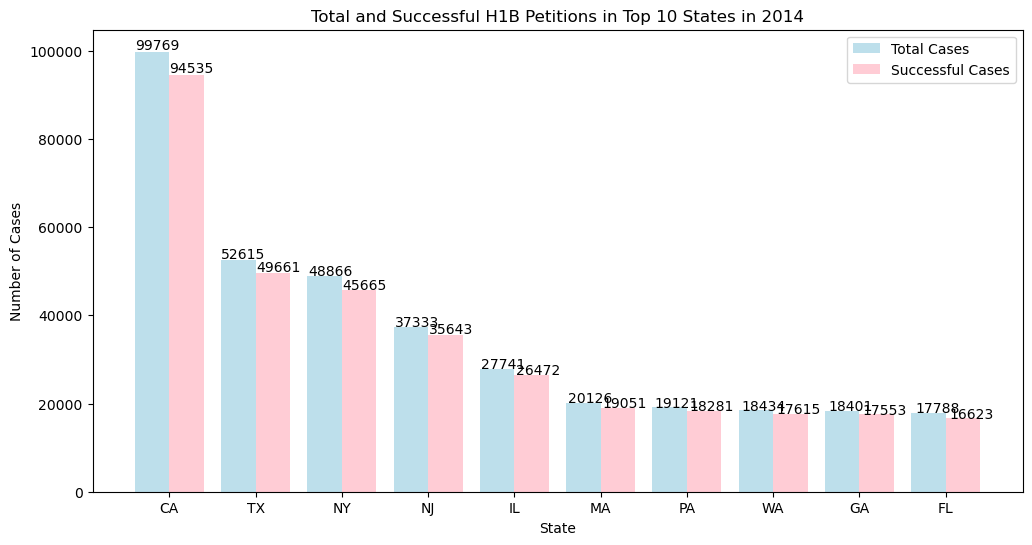

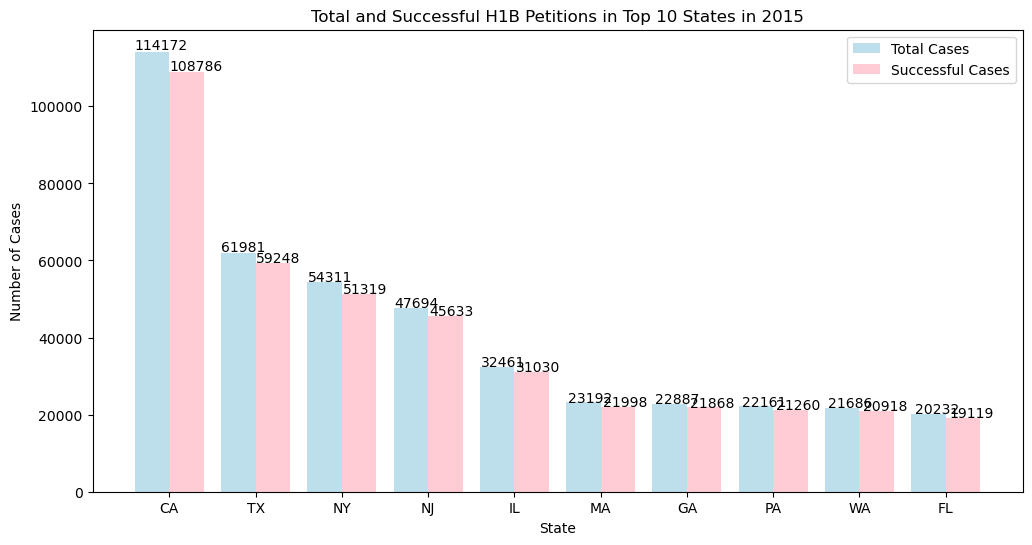

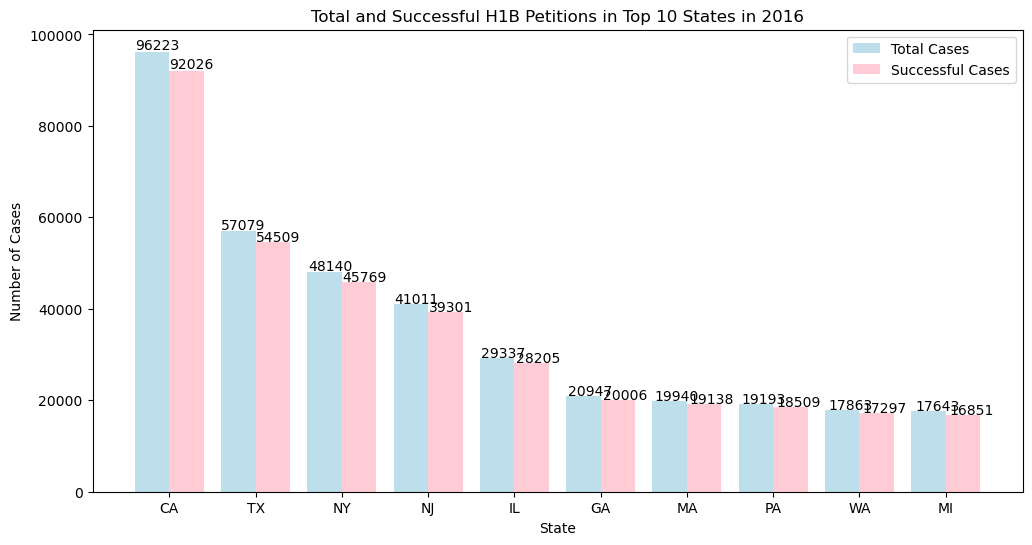

In [106]:
# count of successed and total petitions 
df_sample['case_count'] = 1
state_yearly_data = df_sample.groupby(['worksite_state', 'year']).agg({
    'successful_petition': 'sum',
    'case_count': 'count'
}).reset_index()

# ploting by years
years = [2014, 2015, 2016]

for year in years:
    current_year_data = state_yearly_data[state_yearly_data['year'] == year]
    top_10_states = current_year_data.nlargest(10, 'case_count')

    # bar plot
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(top_10_states['worksite_state']))
    width = 0.4

    ax.bar(x - width/2, top_10_states['case_count'], width, label='Total Cases', color='lightblue', alpha=0.8)
    ax.bar(x + width/2, top_10_states['successful_petition'], width, label='Successful Cases',color='pink', alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(top_10_states['worksite_state'])
    ax.legend()
    ax.set_title(f'Total and Successful H1B Petitions in Top 10 States in {year}')
    ax.set_xlabel('State')
    ax.set_ylabel('Number of Cases')
    
    # Add value labels on the bars
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    

    plt.show()

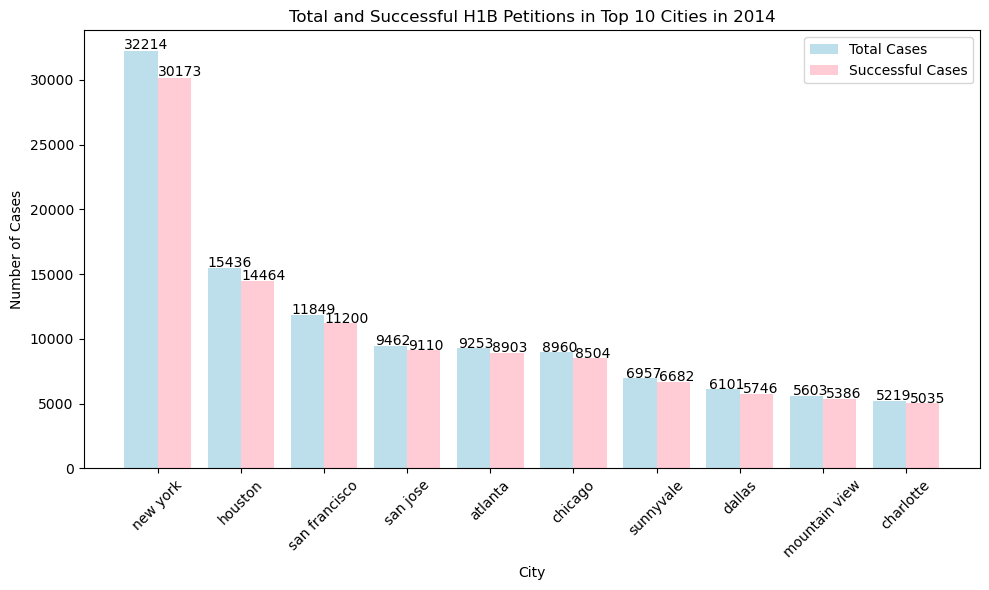

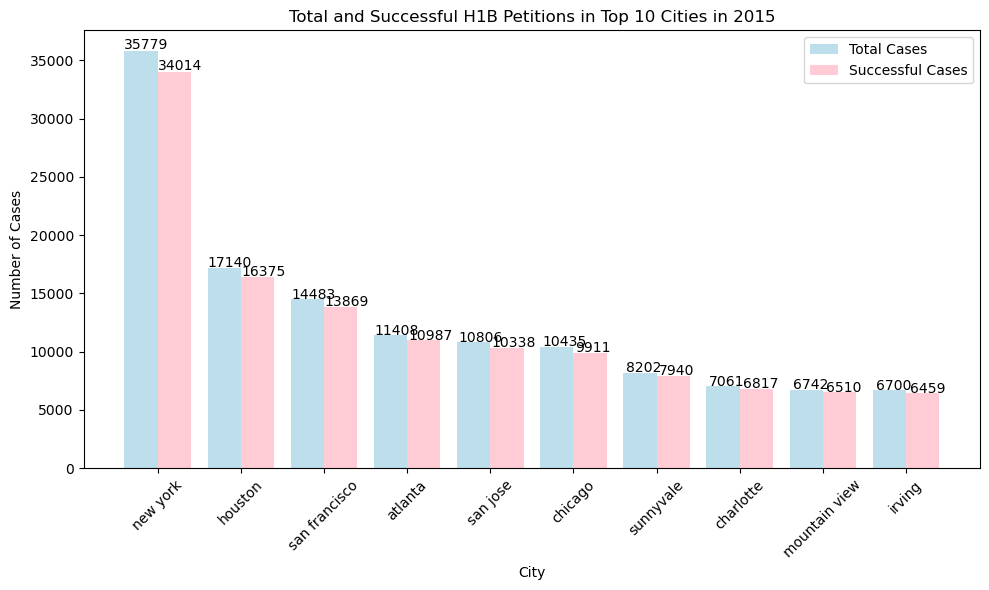

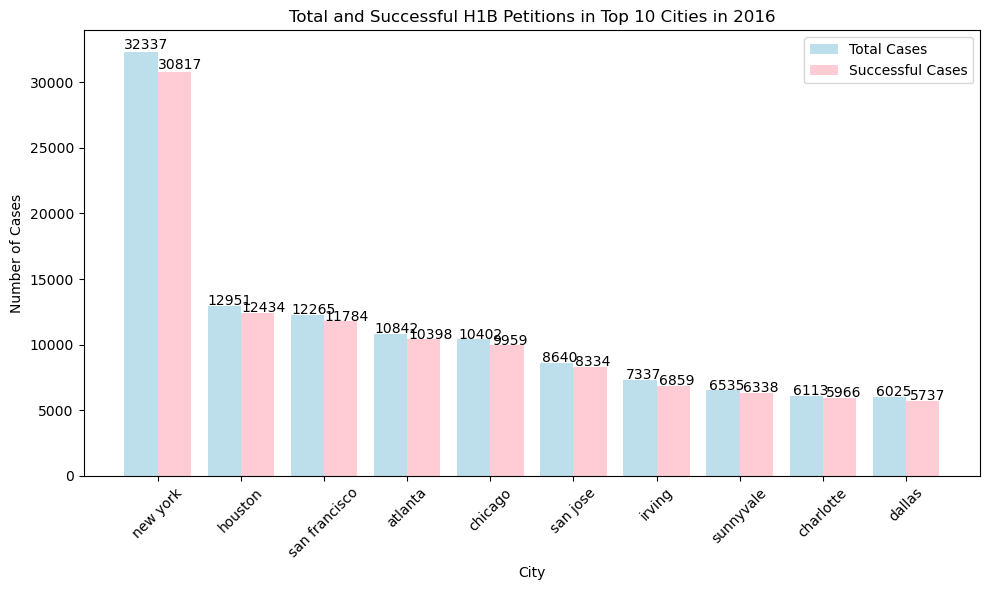

In [93]:
# count of successed and total petitions 
df_sample['case_count'] = 1
city_yearly_data = df_sample.groupby(['worksite_city', 'year']).agg({
    'successful_petition': 'sum',
    'case_count': 'count'
}).reset_index()

# ploting by years
years = [2014, 2015, 2016]

for year in years:
    current_year_data = city_yearly_data[city_yearly_data['year'] == year]
    top_10_cities = current_year_data.nlargest(10, 'case_count')

    # bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(top_10_cities['worksite_city']))
    width = 0.4

    ax.bar(x - width/2, top_10_cities['case_count'], width, label='Total Cases', color='lightblue', alpha=0.8)
    ax.bar(x + width/2, top_10_cities['successful_petition'], width, label='Successful Cases',color='pink', alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(top_10_cities['worksite_city'], rotation=45)
    ax.legend()
    ax.set_title(f'Total and Successful H1B Petitions in Top 10 Cities in {year}')
    ax.set_xlabel('City')
    ax.set_ylabel('Number of Cases')
    
    # Add value labels on the bars
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

    plt.tight_layout() 
    plt.show()


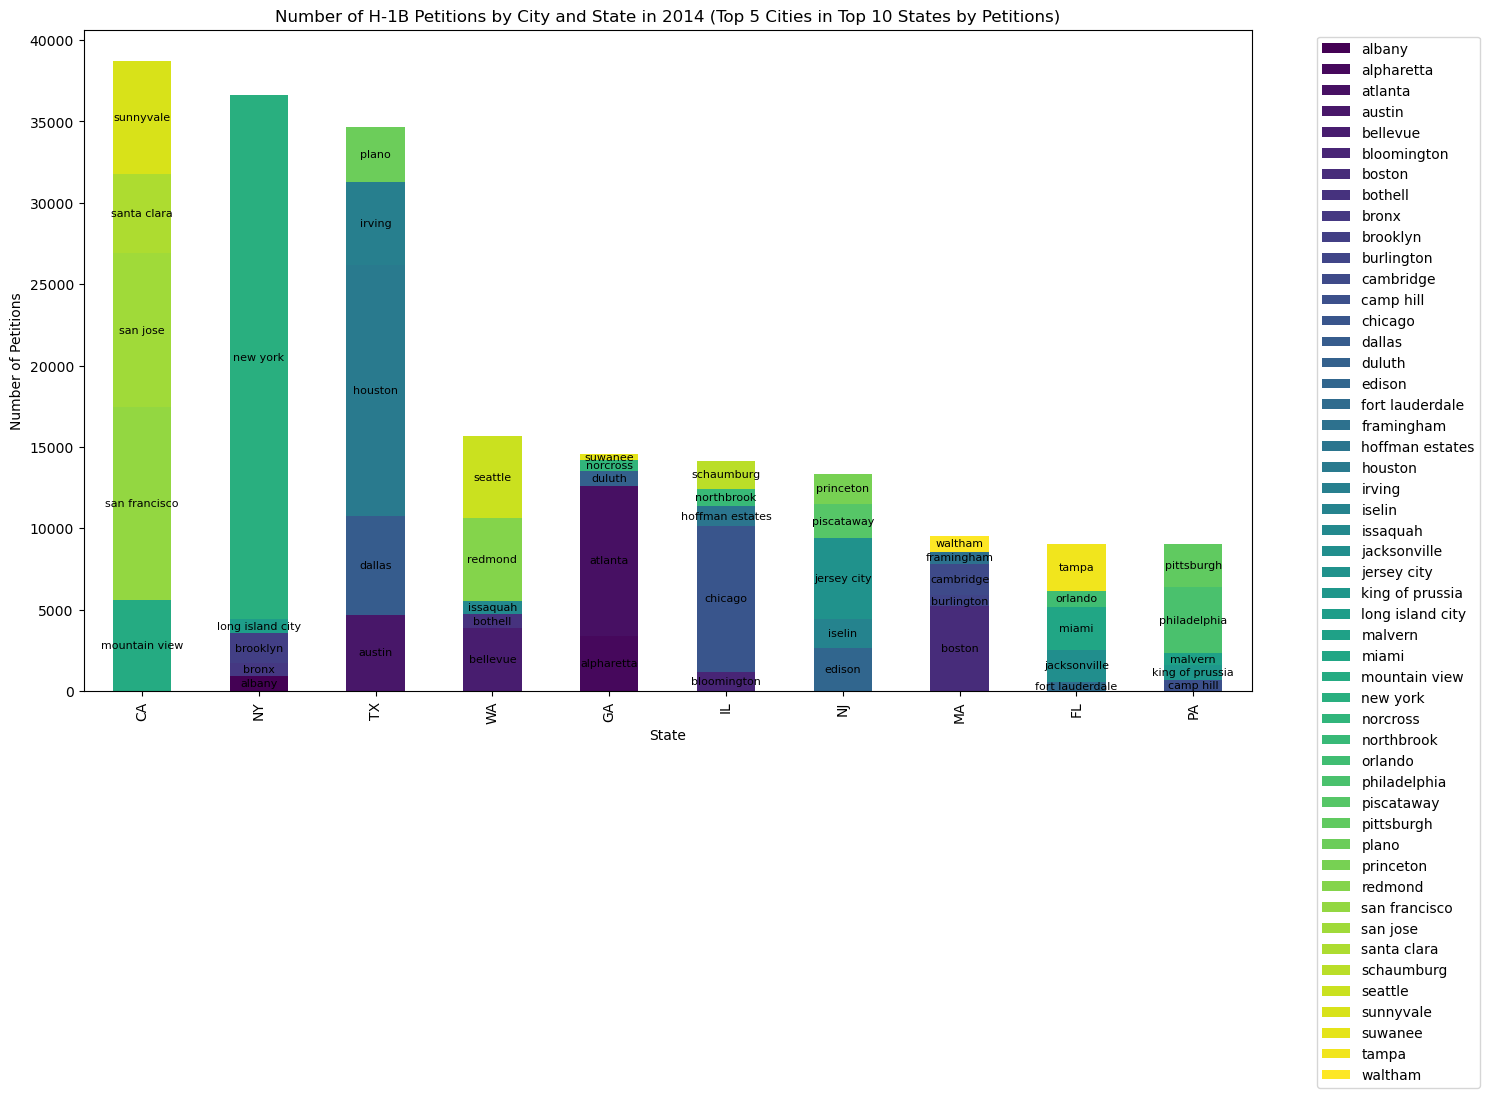

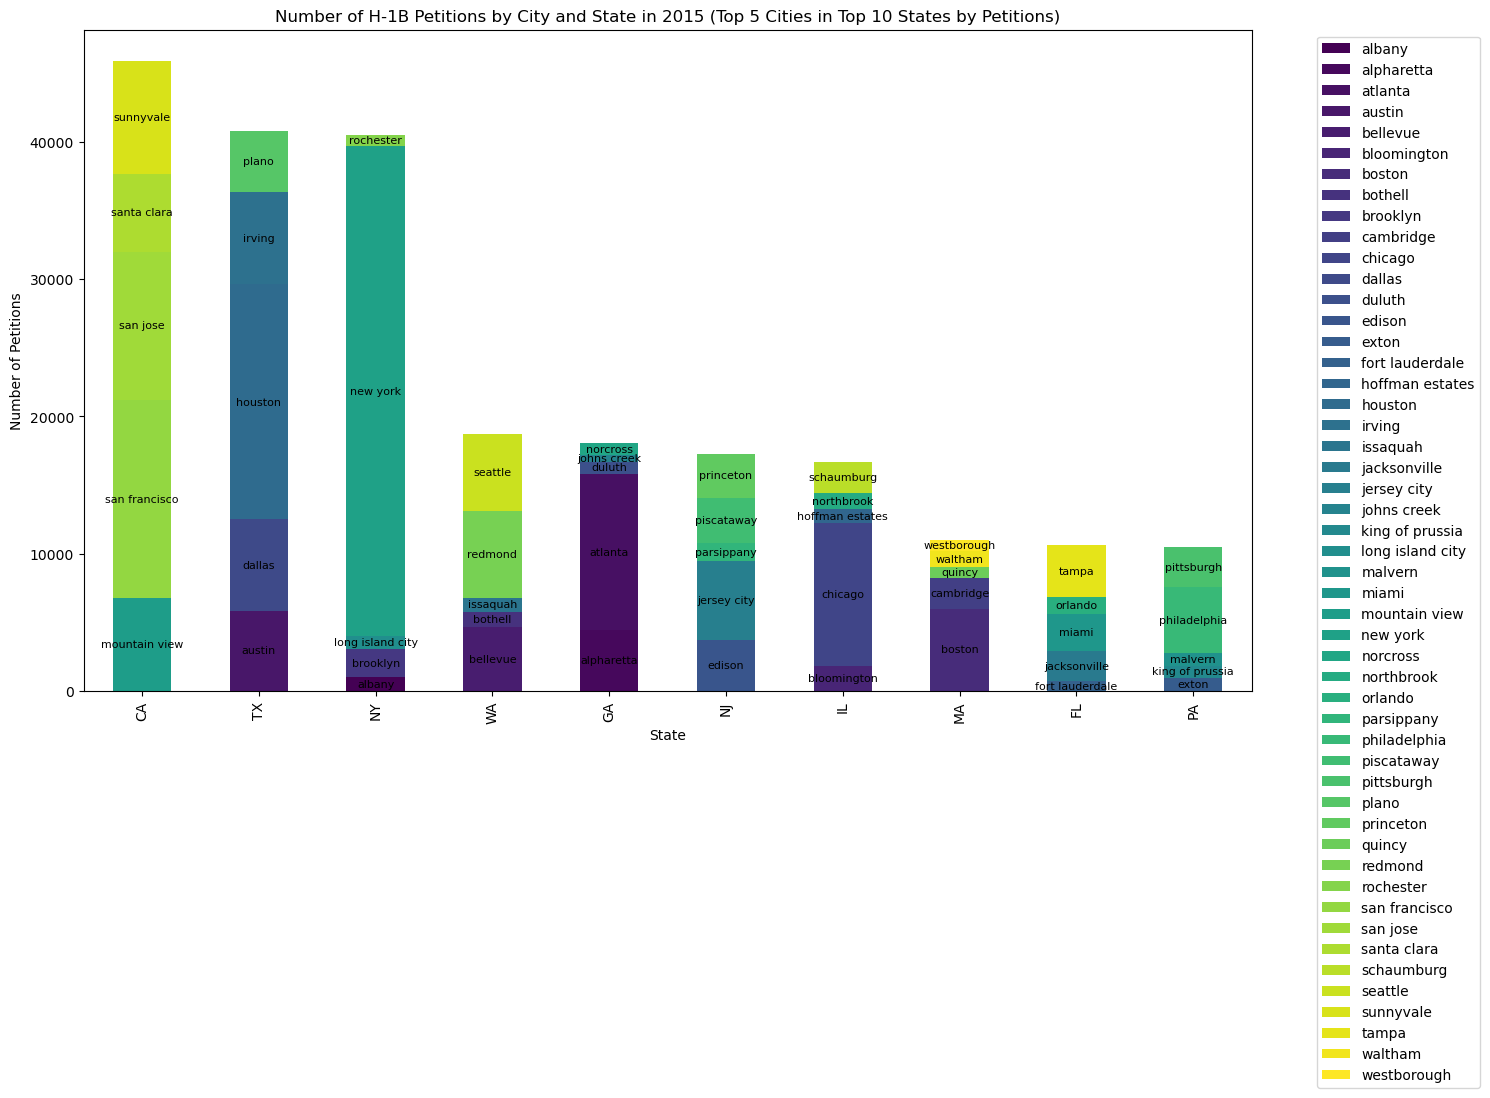

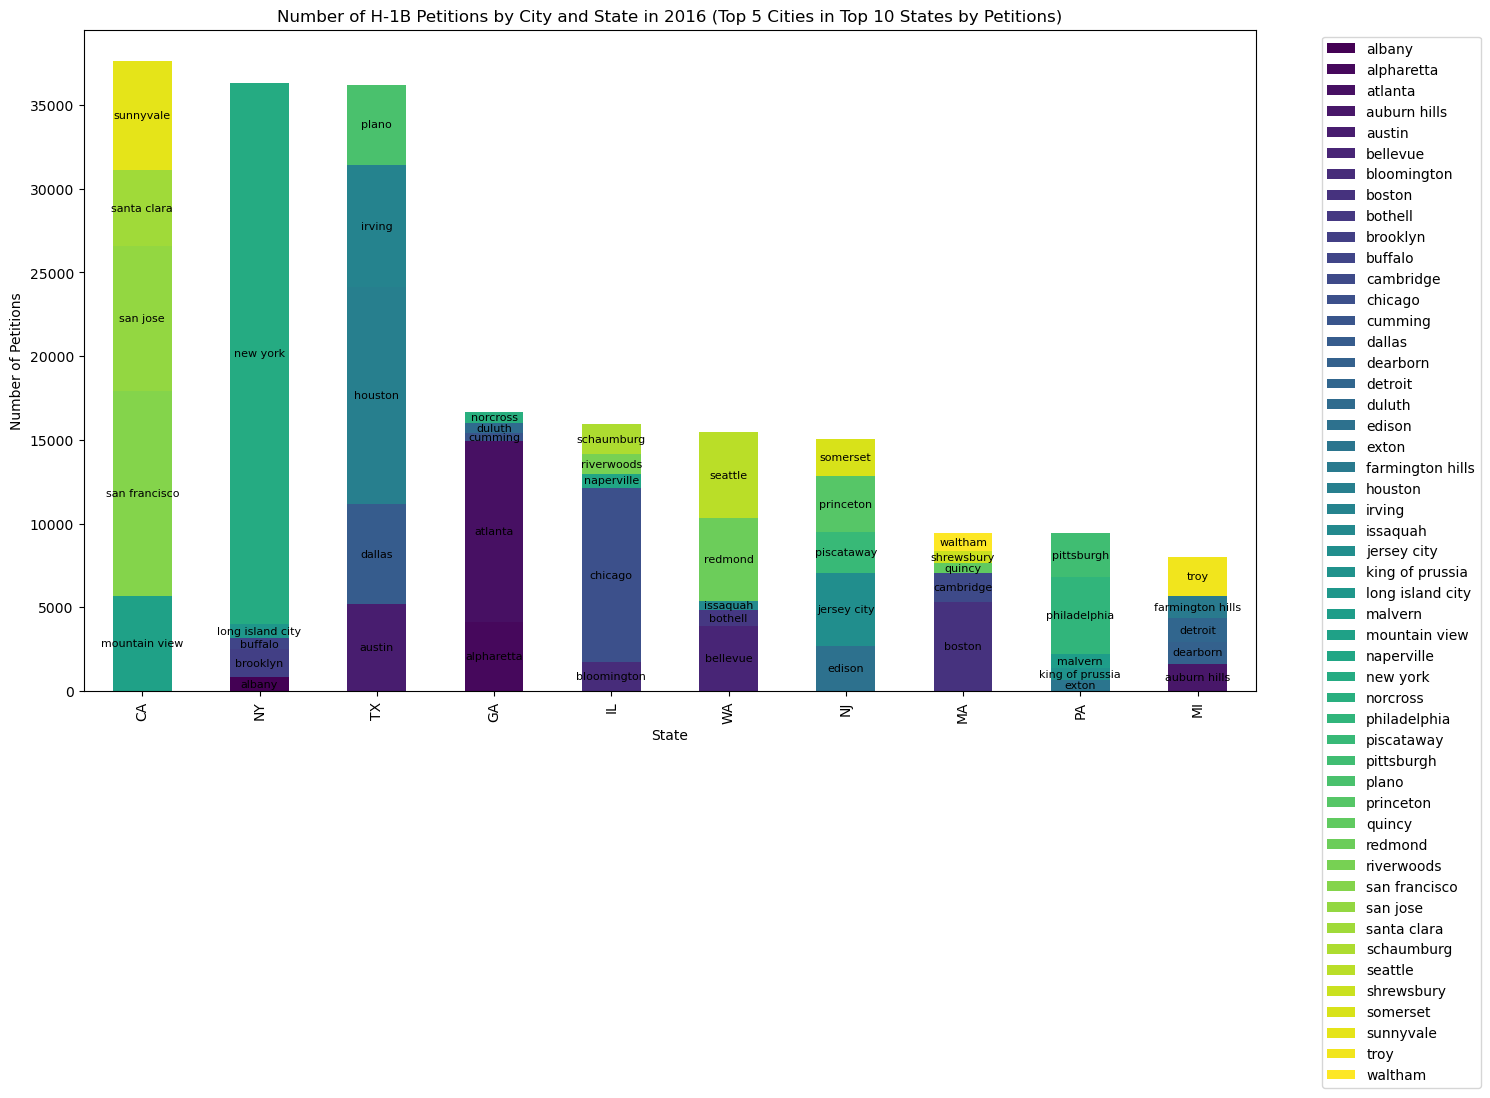

In [115]:
def plot_yearly_data(df_sample, year):
    df_year = df_sample[df_sample['year'] == year]

    # Group the data by state and city, and count the number of petitions
    state_city_data = df_year.groupby(['worksite_state', 'worksite_city']).agg({'case_count': 'count'}).reset_index()

    # First, let's find the top 10 states with the most petitions
    top_10_states_by_petitions = df_year.groupby('worksite_state')['case_count'].sum().nlargest(10).index

    # Filter the state_city_data to only include these states
    filtered_state_city_data = state_city_data[state_city_data['worksite_state'].isin(top_10_states_by_petitions)]

    # Now find the top 5 cities for each of these states
    top_cities_per_state = filtered_state_city_data.groupby('worksite_state').apply(lambda x: x.nlargest(5, 'case_count')).reset_index(drop=True)

    # Pivot the data to have states as rows, cities as columns, and counts as values
    top_cities_pivot = top_cities_per_state.pivot(index='worksite_state', columns='worksite_city', values='case_count').fillna(0)

    # Sort the states by the total number of petitions
    sorted_states = top_cities_pivot.sum(axis=1).sort_values(ascending=False).index
    top_cities_pivot = top_cities_pivot.reindex(sorted_states)

    # Get the colormap and create a normalization object
    cmap = plt.get_cmap('viridis')
    norm = plt.Normalize(top_cities_pivot.values.min(), top_cities_pivot.values.max())

    # Plot the data as a stacked bar plot
    ax = top_cities_pivot.plot(kind='bar', stacked=True, figsize=(15, 10), colormap=cmap)

    # Add city names to the plot
    for state in range(len(sorted_states)):
        y_offset = 0
        for city in range(len(top_cities_pivot.columns)):
            count = top_cities_pivot.iloc[state, city]
            if count > 0:
                ax.text(state, y_offset + count/2., top_cities_pivot.columns[city], ha='center', va='center', fontsize=8)
                y_offset += count

    # Move the legend to the right of the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.title(f'Number of H-1B Petitions by City and State in {year} (Top 5 Cities in Top 10 States by Petitions)')
    plt.xlabel('State')
    plt.ylabel('Number of Petitions')
    plt.tight_layout()
    plt.show()

# Run the function for each year
plot_yearly_data(df_sample, 2014)
plot_yearly_data(df_sample, 2015)
plot_yearly_data(df_sample, 2016)


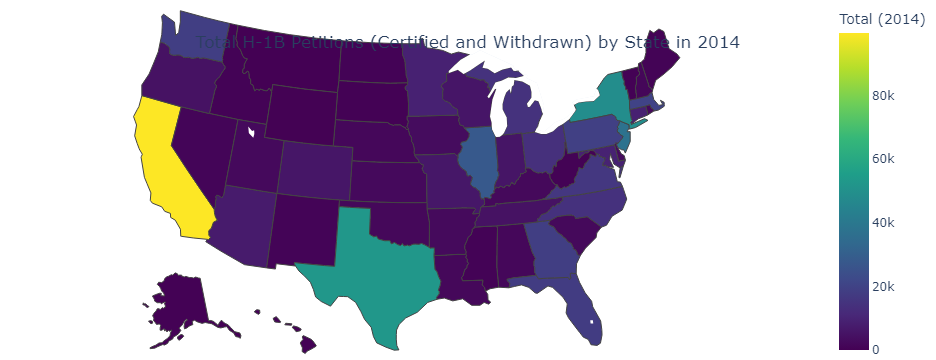

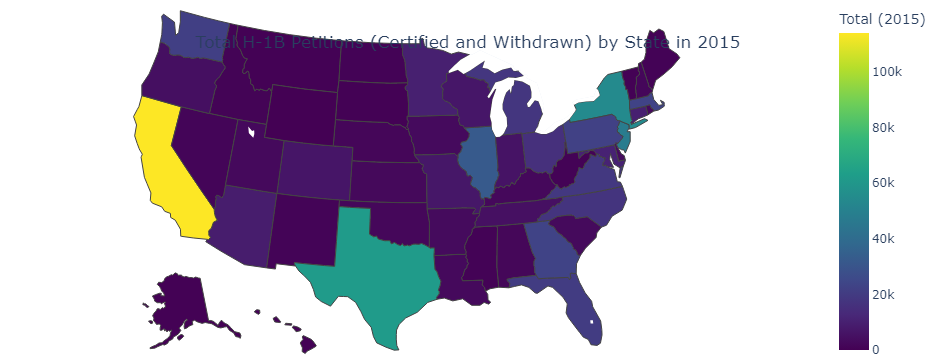

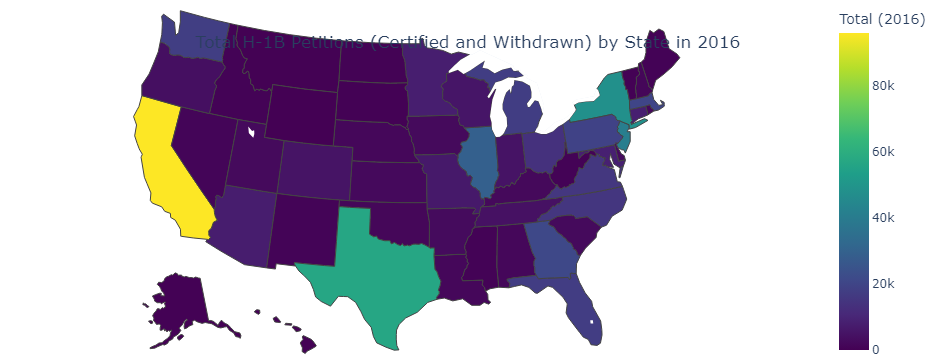

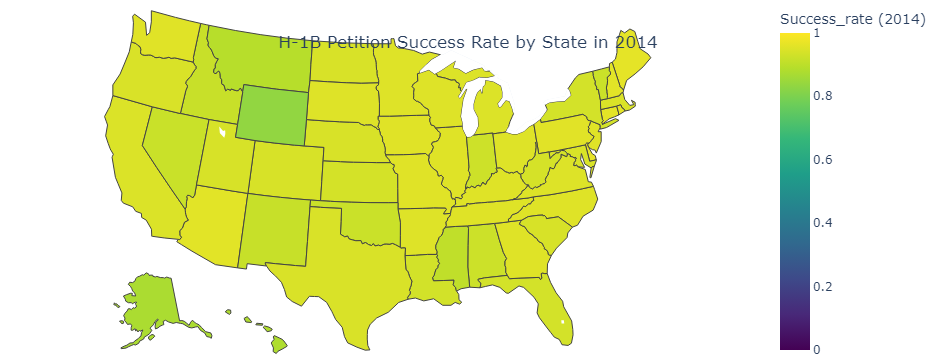

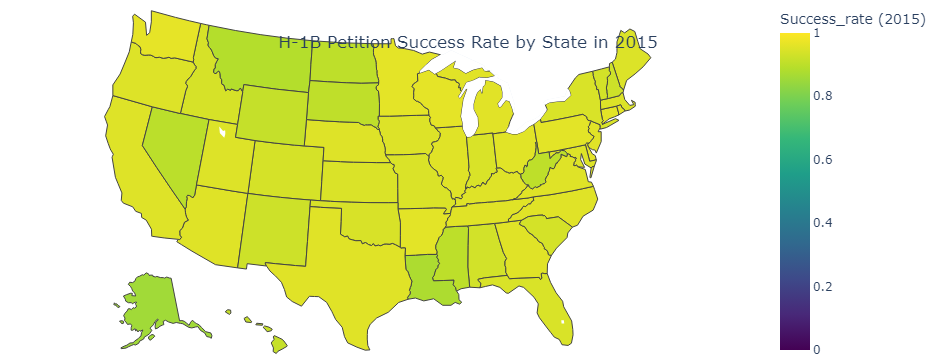

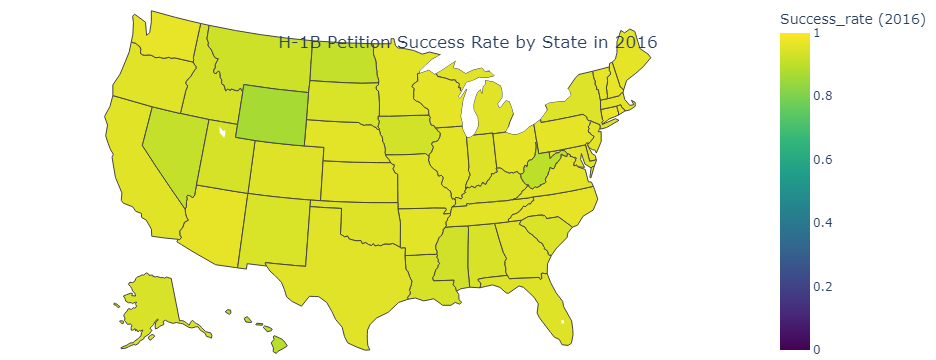

In [80]:
df_sample['successful'] = df_sample['case_status'].isin(['certified', 'certified-withdrawn']).astype(int)
df_sample['worksite_state'] = df_sample['worksite_state'].str.upper()
state_year_data = df_sample.groupby(['year', 'worksite_state']).agg(
    {'case_status': 'count', 'successful': ['sum', 'mean']}
).reset_index()
state_year_data.columns = ['year', 'worksite_state', 'total', 'certified', 'success_rate']

min_success_rate = state_year_data['success_rate'].min()
max_success_rate = state_year_data['success_rate'].max()

def plot_choropleth_map(year, metric):
    year_data = state_year_data[state_year_data['year'] == year]

    if metric == 'total':
        title_text = f'Total H-1B Petitions (Certified and Withdrawn) by State in {year}'
    else:
        title_text = f'H-1B Petition Success Rate by State in {year}'

    fig = px.choropleth(
        year_data,
        locations='worksite_state',
        color=metric,
        color_continuous_scale='Viridis',
        locationmode='USA-states',
        scope='usa',
        labels={metric: f'{metric.capitalize()} ({year})'},
        range_color=(min_success_rate, max_success_rate) if metric == 'success_rate' else None,
    )

    fig.update_layout(
        title={
            'text': title_text,
            'y': 0.9,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        margin={"r":0,"t":0,"l":0,"b":0}
    )

    fig.show()

plot_choropleth_map(2014, 'total')
plot_choropleth_map(2015, 'total')
plot_choropleth_map(2016, 'total')

plot_choropleth_map(2014, 'success_rate')
plot_choropleth_map(2015, 'success_rate')
plot_choropleth_map(2016, 'success_rate')


#### 3.1.4 Results
From a state perspective, California has the highest total number of applications, followed by New York and Texas. However, when looking at the ranking of cities, New York City has the highest number of applications among all cities in the United States. The number of applications from other cities in New York State is far less than that of New York City, but several major cities in California have relatively high numbers of applications, which results in the highest total number for California. From 2014 to 2016, the success rates of applications in each state were fairly close. Lower success rates occurred in states with relatively fewer total applications.

### 3.2 Employer

#### 3.2.1 Which employers file the most petitions each year?  

In [63]:
# number of certified, withdrawn for each employer
employer_petitions_by_year = df_sample.groupby(['year', 'employer_name', 'case_status']).size().reset_index(name='num_petitions')
employer_petitions_by_year = employer_petitions_by_year.pivot_table(index=['year', 'employer_name'], columns='case_status', values='num_petitions', fill_value=0).reset_index()

# success rate
employer_petitions_by_year['total_petitions'] = employer_petitions_by_year['certified'] + employer_petitions_by_year['certified-withdrawn'] + employer_petitions_by_year['denied'] + employer_petitions_by_year['withdrawn']
employer_petitions_by_year['success_rate'] = (employer_petitions_by_year['certified'] + employer_petitions_by_year['certified-withdrawn']) / employer_petitions_by_year['total_petitions']

# ascending rank
employer_petitions_by_year = employer_petitions_by_year.sort_values(['year', 'total_petitions'], ascending=[True, False])

# groupby year
def print_group(group):
    print(f"submitted year: {group['year'].iloc[0]}")
    print(group[['employer_name', 'certified', 'certified-withdrawn', 'denied', 'withdrawn', 'success_rate']].head(10))
    print("\n")

employer_petitions_by_year.groupby('year').apply(print_group)

submitted year: 2009
case_status                                      employer_name  certified  \
1            university of texas health science center at s...          0   
0                  optimal solutions & technologies (ost), inc          0   
2                      ut health science center at san antonio          0   

case_status  certified-withdrawn  denied  withdrawn  success_rate  
1                              2       0          0          1.00  
0                              1       0          0          1.00  
2                              1       0          0          1.00  


submitted year: 2010
case_status                               employer_name  certified  \
15                                            akken inc          0   
23                  baltimore city public school system          0   
147                           revision technologies inc          0   
196          trustees of the university of pennsylvania          0   
30                       

Empty DataFrame
Columns: []
Index: []

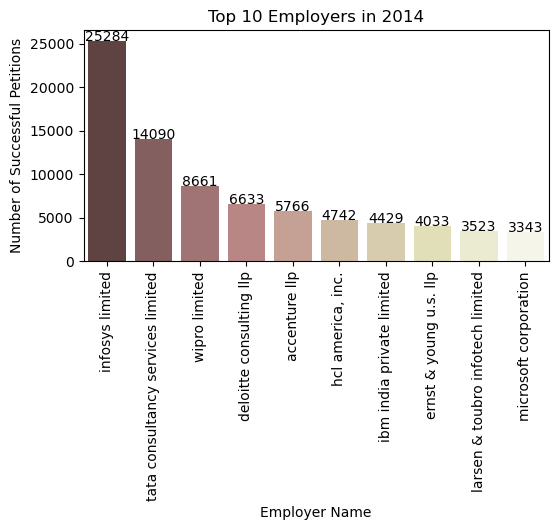

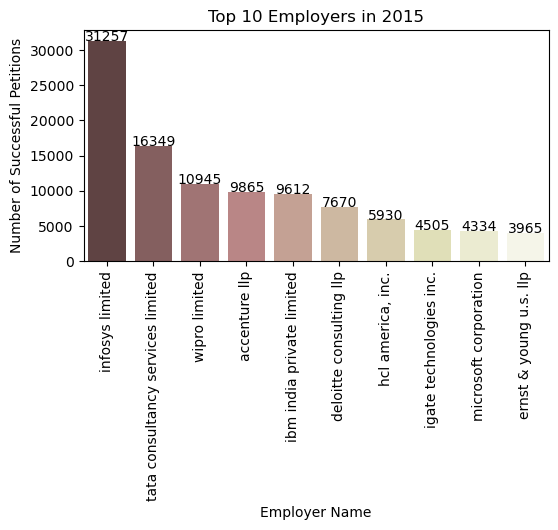

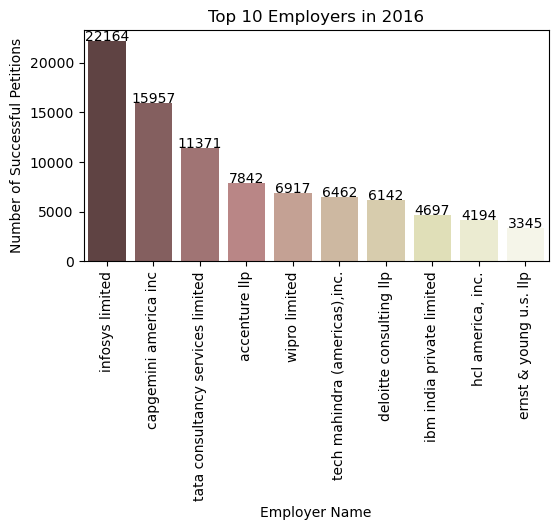

In [64]:
def plot_top_employers(year_data, year):
    top_10_employers = year_data.groupby('employer_name')['certified'].sum().nlargest(10)

    plt.figure(figsize=(6, 3))
    ax = sns.barplot(x=top_10_employers.index, y=top_10_employers.values, palette='pink')
    plt.xticks(rotation=90)
    plt.xlabel("Employer Name")
    plt.ylabel("Number of Successful Petitions")
    plt.title(f"Top 10 Employers in {year}")

    for index, value in enumerate(top_10_employers.values):
        ax.text(index, value+0.5, str(value), ha='center')

    plt.show()

years = [2014, 2015, 2016]

for year in years:
    year_data = employer_petitions_by_year[employer_petitions_by_year['year'] == year]
    plot_top_employers(year_data, year)

#### 3.2.2 Where are Top 10 employers located?

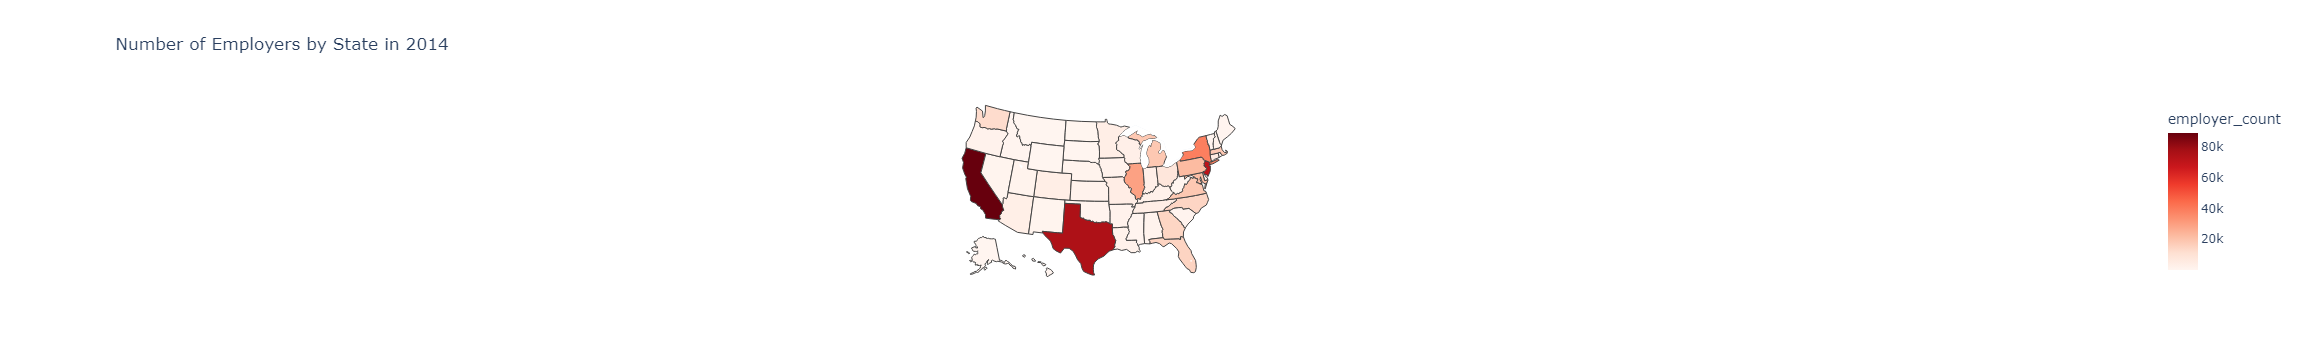

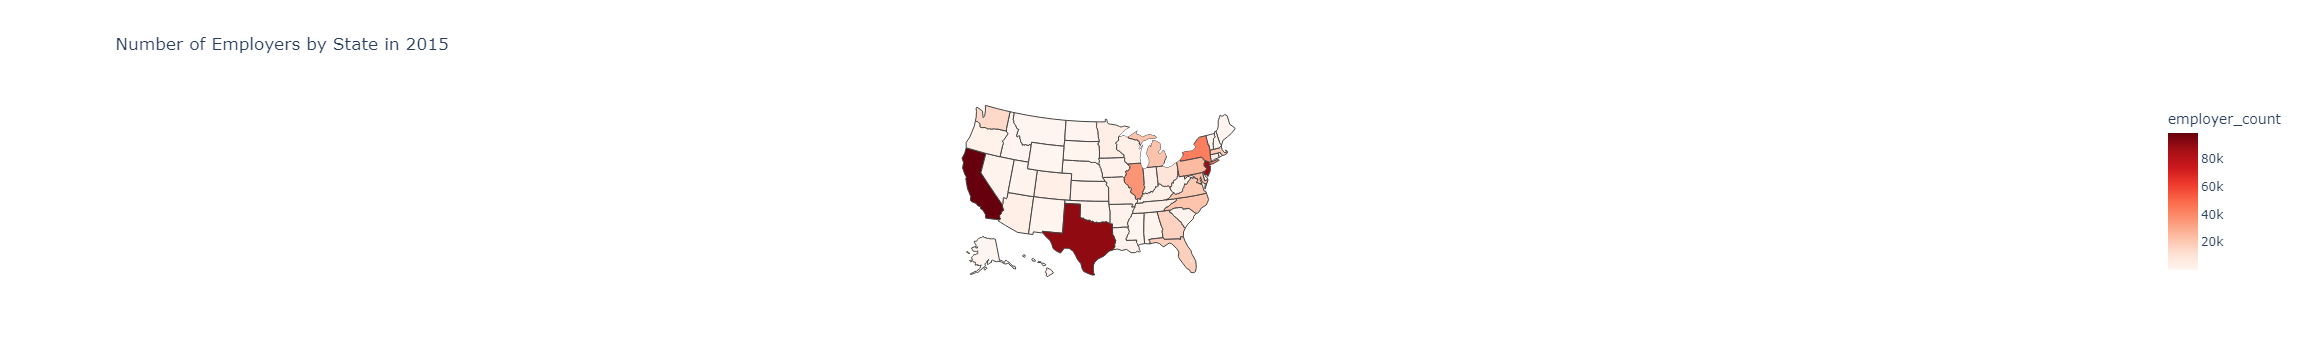

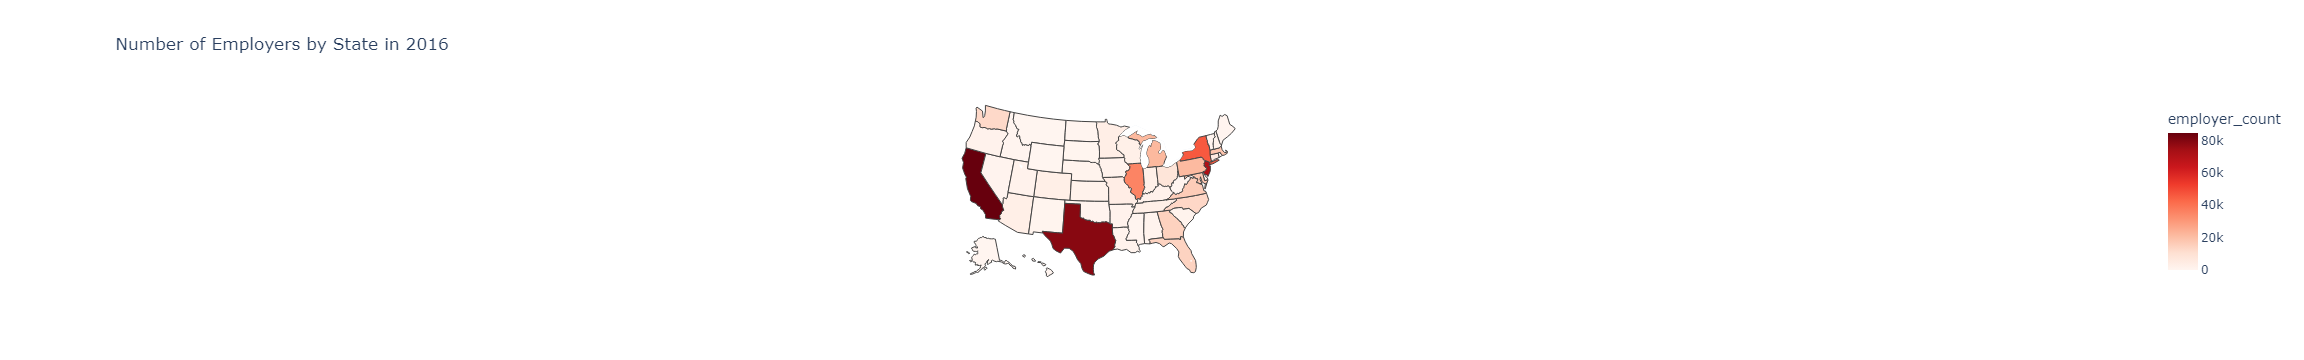

In [124]:
import plotly.express as px

years = [2014, 2015, 2016]

for year in years:
    # Filter the data for the current year
    current_year_data = df_sample[df_sample['year'] == year].copy()  # Make a copy of the data for the current year
    
    # Convert the 'employer_state' to upper case
    current_year_data.loc[:, 'employer_state'] = current_year_data['employer_state'].str.upper()

    # Count the number of employers in each state
    state_employer_counts = current_year_data.groupby('employer_state').size().reset_index(name='employer_count')

    # Create a choropleth map
    fig = px.choropleth(state_employer_counts, 
                        locations='employer_state',
                        color='employer_count',
                        locationmode='USA-states',
                        scope='usa',
                        title=f'Number of Employers by State in {year}',
                        color_continuous_scale='Reds')
    fig.show()


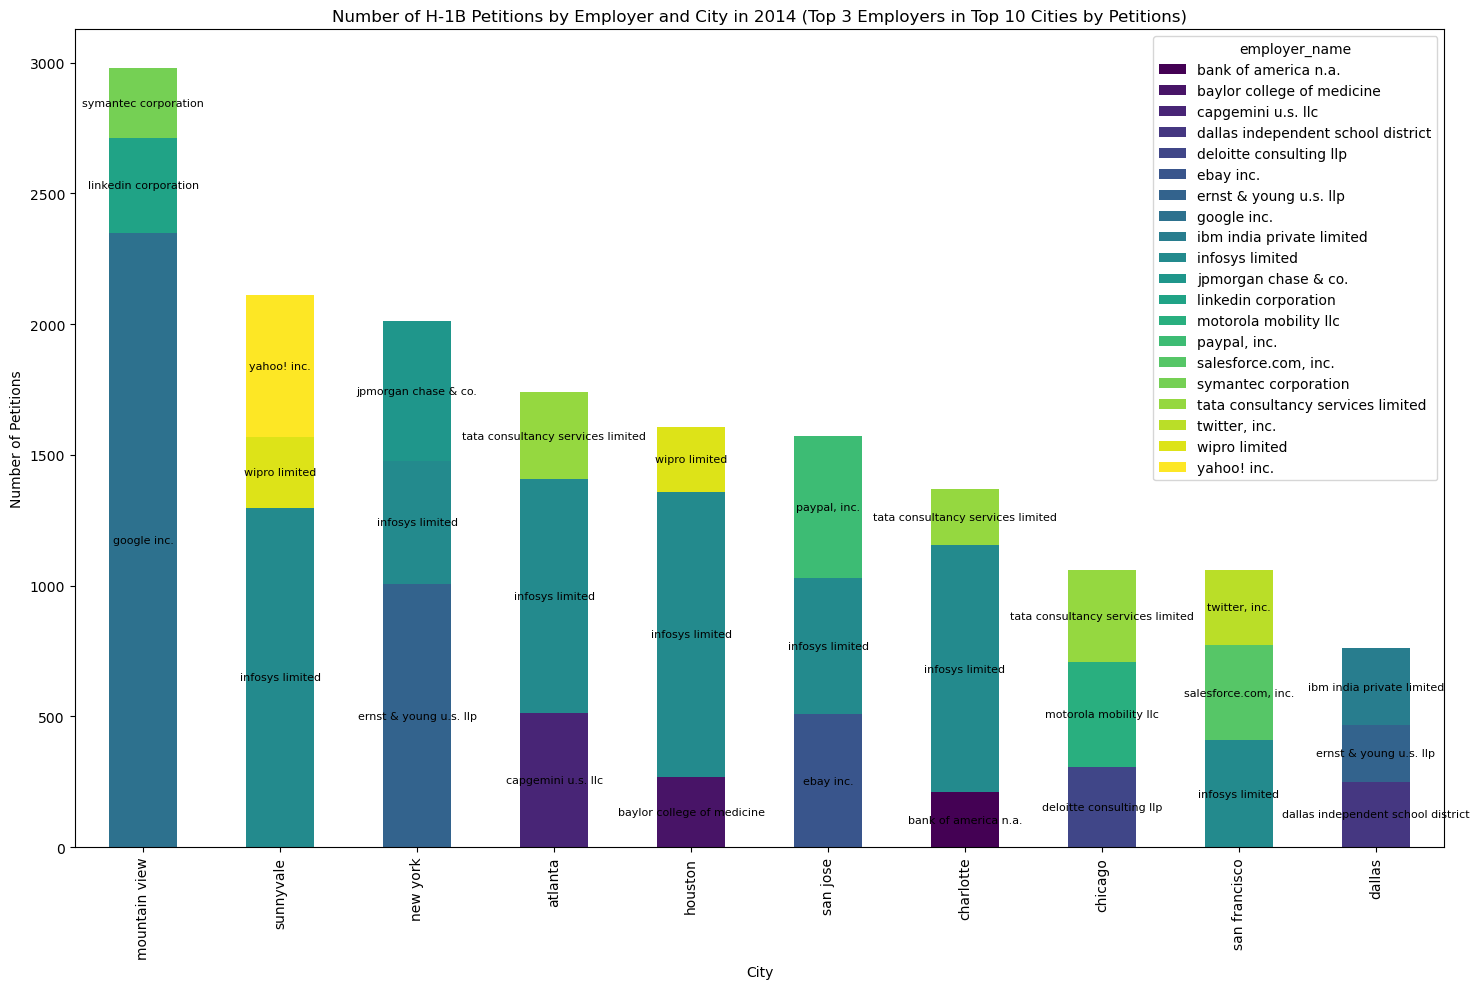

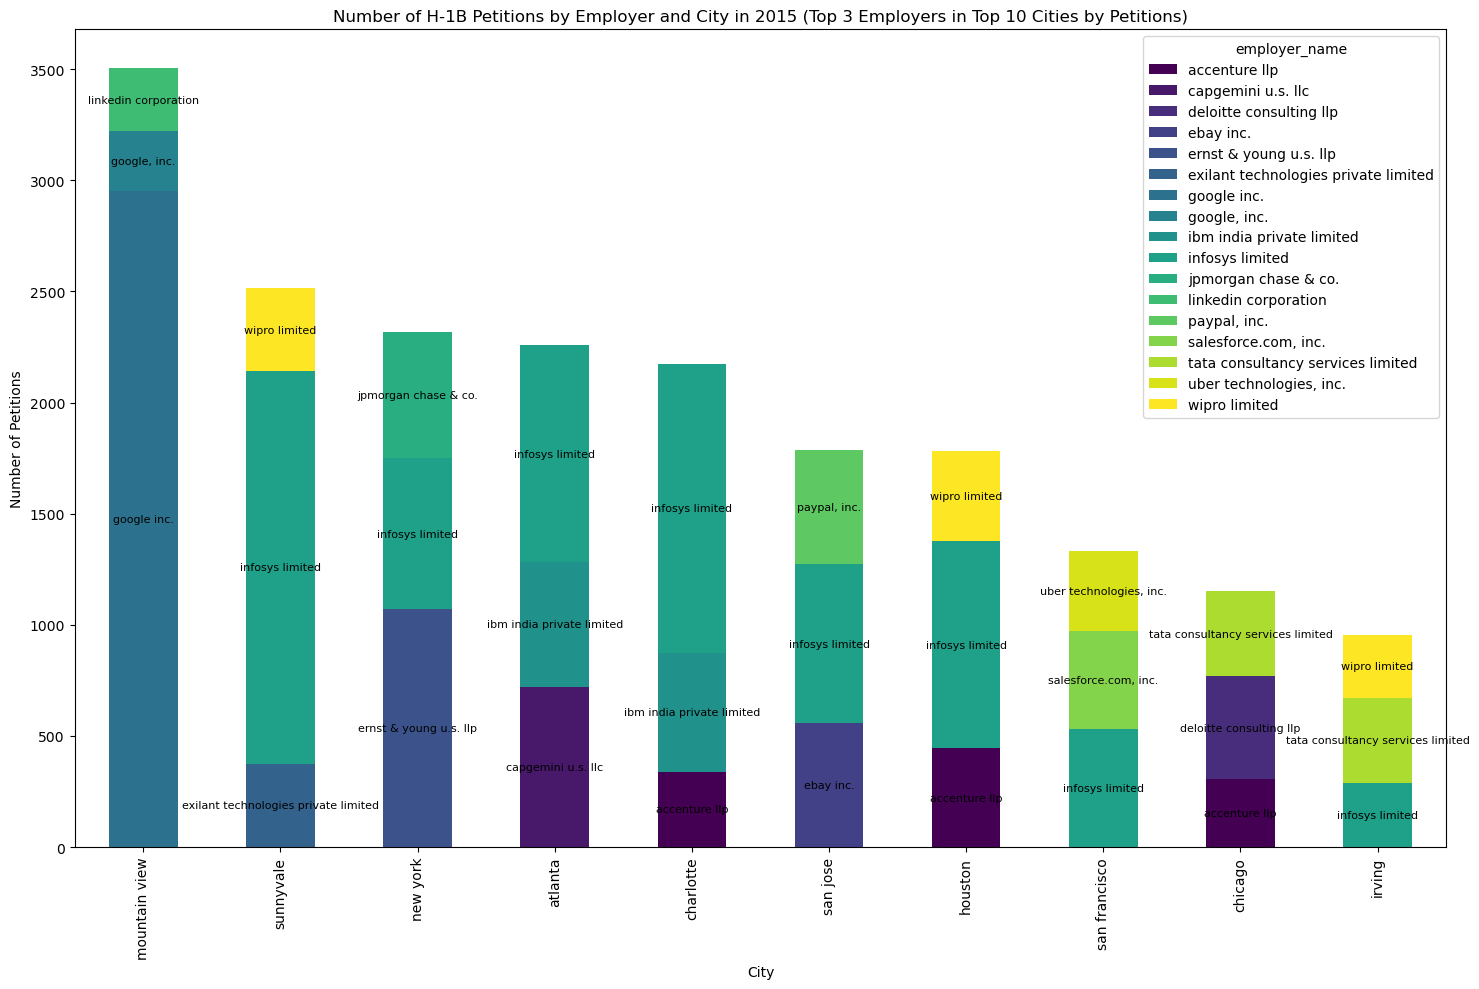

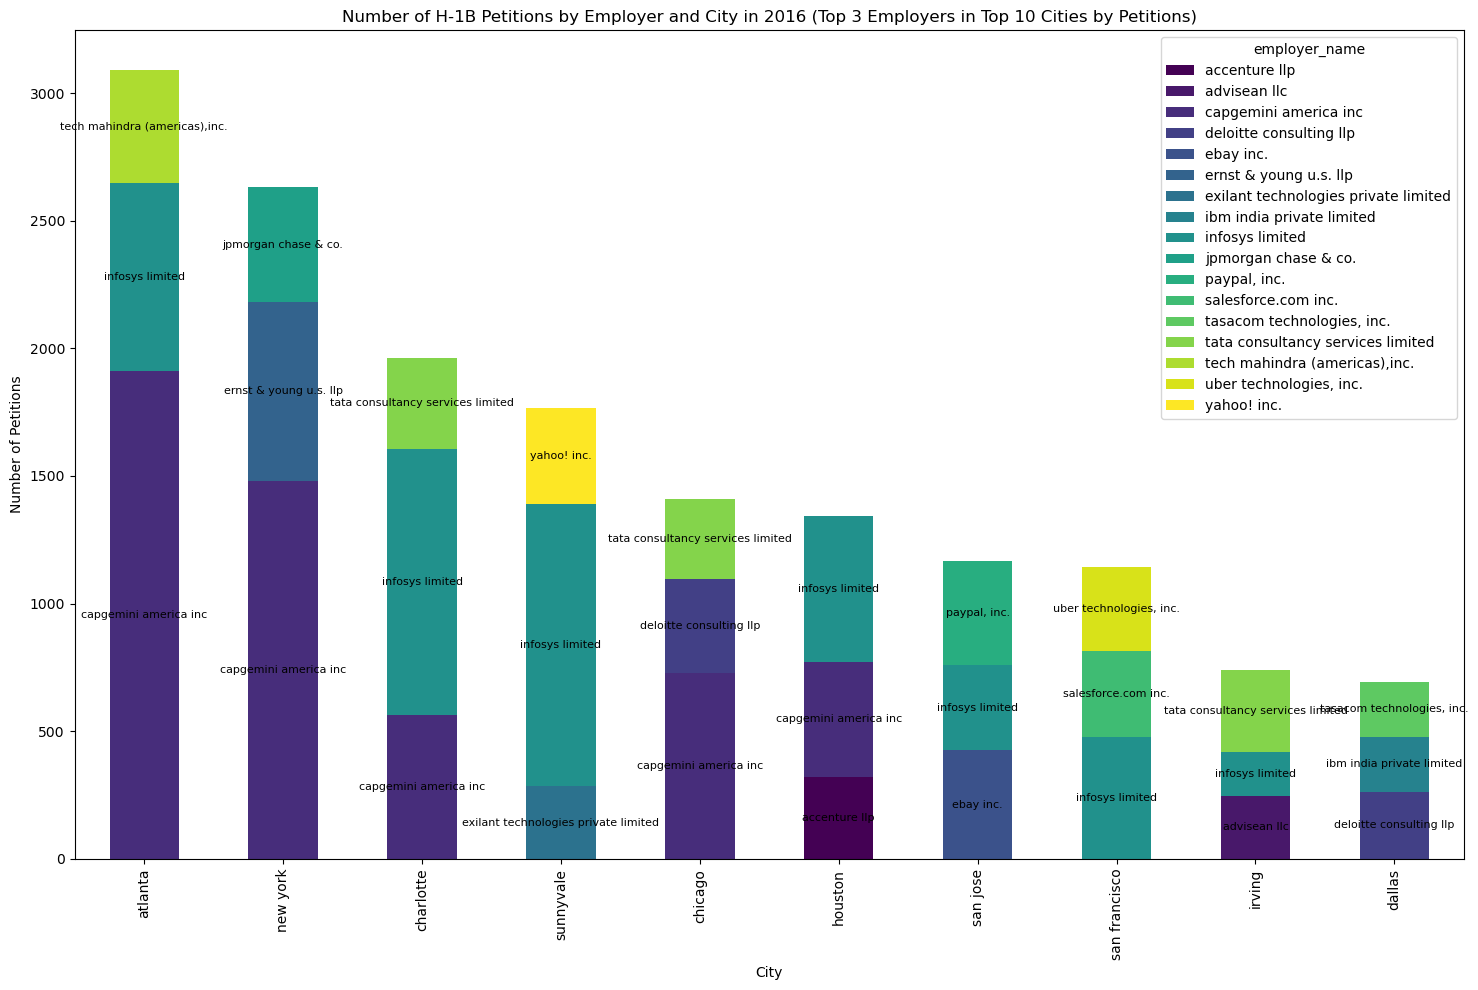

In [131]:
def plot_yearly_data(df_sample, year):
    df_year = df_sample[df_sample['year'] == year]

    # Group the data by city and employer, and count the number of petitions
    city_employer_data = df_year.groupby(['worksite_city', 'employer_name']).agg({'case_count': 'count'}).reset_index()

    # First, let's find the top 10 cities with the most petitions
    top_10_cities_by_petitions = df_year.groupby('worksite_city')['case_count'].sum().nlargest(10).index

    # Filter the city_employer_data to only include these cities
    filtered_city_employer_data = city_employer_data[city_employer_data['worksite_city'].isin(top_10_cities_by_petitions)]

    # Now find the top 3 employers for each of these cities
    top_employers_per_city = filtered_city_employer_data.groupby('worksite_city').apply(lambda x: x.nlargest(3, 'case_count')).reset_index(drop=True)

    # Pivot the data to have cities as rows, employers as columns, and counts as values
    top_employers_pivot = top_employers_per_city.pivot(index='worksite_city', columns='employer_name', values='case_count').fillna(0)

    # Sort the cities by the total number of petitions
    sorted_cities = top_employers_pivot.sum(axis=1).sort_values(ascending=False).index
    top_employers_pivot = top_employers_pivot.reindex(sorted_cities)

    # Get the colormap and create a normalization object
    cmap = plt.get_cmap('viridis')

    # Plot the data as a stacked bar plot
    ax = top_employers_pivot.plot(kind='bar', stacked=True, figsize=(15, 10), colormap=cmap)

    # Add employer names to the plot
    for city in range(len(sorted_cities)):
        y_offset = 0
        for employer in range(len(top_employers_pivot.columns)):
            count = top_employers_pivot.iloc[city, employer]
            if count > 0:
                ax.text(city, y_offset + count/2., top_employers_pivot.columns[employer], ha='center', va='center', fontsize=8)
                y_offset += count

    plt.title(f'Number of H-1B Petitions by Employer and City in {year} (Top 3 Employers in Top 10 Cities by Petitions)')
    plt.xlabel('City')
    plt.ylabel('Number of Petitions')
    plt.tight_layout()
    plt.show()

# Run the function for each year
plot_yearly_data(df_sample, 2014)
plot_yearly_data(df_sample, 2015)
plot_yearly_data(df_sample, 2016)


#### 3.2.3 Results
According to the results presented above, we can observe that Infosys Limited filed the highest number of petitions in each year. Additionally, in 2016, Capgemini submitted a large number of applications.   
We also noticed that Plano, Texas has a similar number of employers to that of New York City, but it did not make it to the top ten cities in terms of total number of petitions filed. This is because some of the employers with high petition volumes (such as Infosys Limited) are located in Texas, but their employees work in other states (such as California), as shown in the graph below.

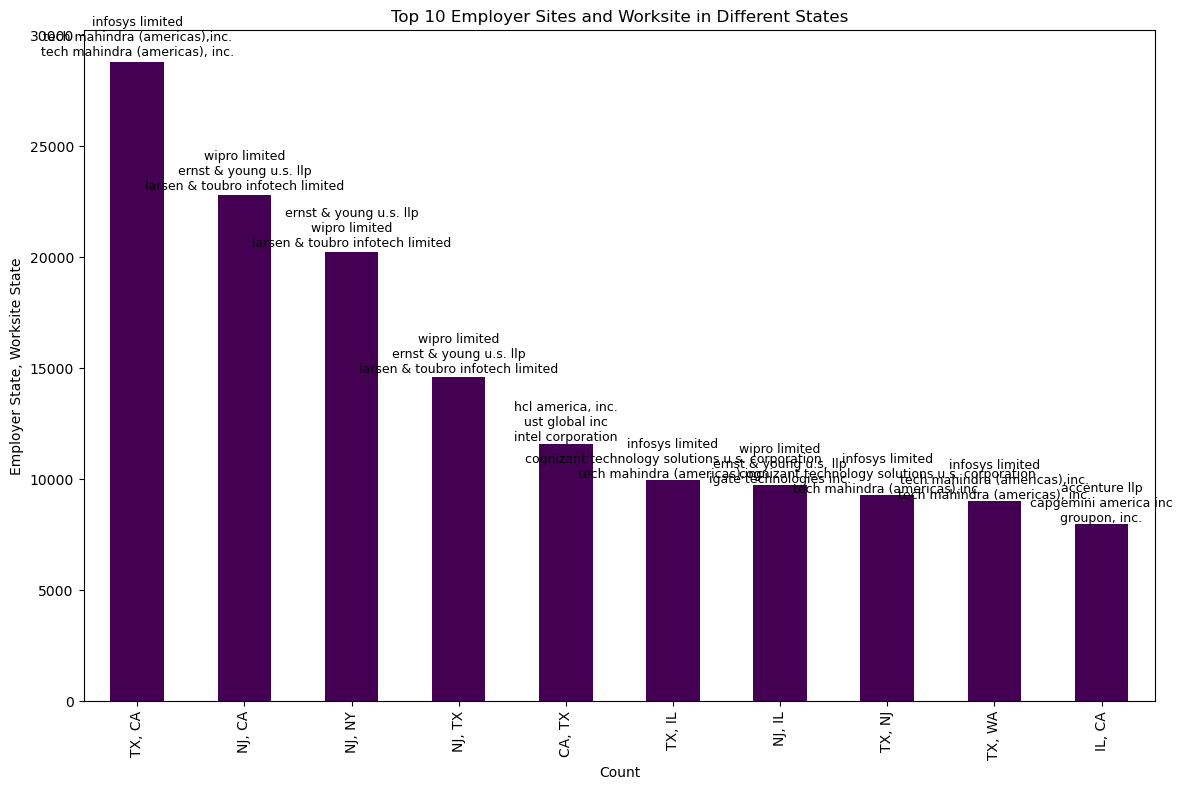

In [138]:
# Convert employer_state and worksite_state to upper case
df_sample['employer_state'] = df_sample['employer_state'].str.upper()
df_sample['worksite_state'] = df_sample['worksite_state'].str.upper()

# Create a new DataFrame with rows where employer_state and worksite_state are different
df_different_states = df_sample[df_sample['employer_state'] != df_sample['worksite_state']]

# Calculate the count of different employer_state and worksite_state combinations
state_combinations = df_different_states.groupby(['employer_state', 'worksite_state']).size().reset_index(name='count')

# Sort by count and get the top 10 combinations
top_combinations = state_combinations.sort_values('count', ascending=False).head(10)

# Create a new column with the combination of employer_state and worksite_state
top_combinations['state_pair'] = top_combinations['employer_state'] + ', ' + top_combinations['worksite_state']

# Plot the top 10 combinations
fig, ax = plt.subplots(figsize=(12, 8))
bar_plot = top_combinations.plot(kind='bar', x='state_pair', y='count', legend=False, ax=ax, colormap='viridis')

# Sort the data for top 3 employers for each state_pair
top_employers = df_different_states.groupby(['employer_state', 'worksite_state', 'employer_name']).size().reset_index(name='count')
top_employers = top_employers.sort_values(['employer_state', 'worksite_state', 'count'], ascending=[True, True, False])
top_employers = top_employers.groupby(['employer_state', 'worksite_state']).head(3)

# Annotate the bar chart with top 3 employers for each state_pair
for i, bar in enumerate(bar_plot.containers[0]):
    state_pair = top_combinations.iloc[i]['state_pair']
    top_employer_names = top_employers[top_employers['employer_state'] + ', ' + top_employers['worksite_state'] == state_pair]['employer_name']
    employer_annotation = '\n'.join(top_employer_names)
    ax.annotate(employer_annotation, xy=(i, bar.get_height()), xytext=(i, bar.get_height() * 1.01), fontsize=9, ha='center')

plt.xlabel('Count')
plt.ylabel('Employer State, Worksite State')
plt.title('Top 10 Employer Sites and Worksite in Different States')
plt.tight_layout()
plt.show()

### 3.3 Job

#### 3.3.1 What jobs with the highest number of applications each year?

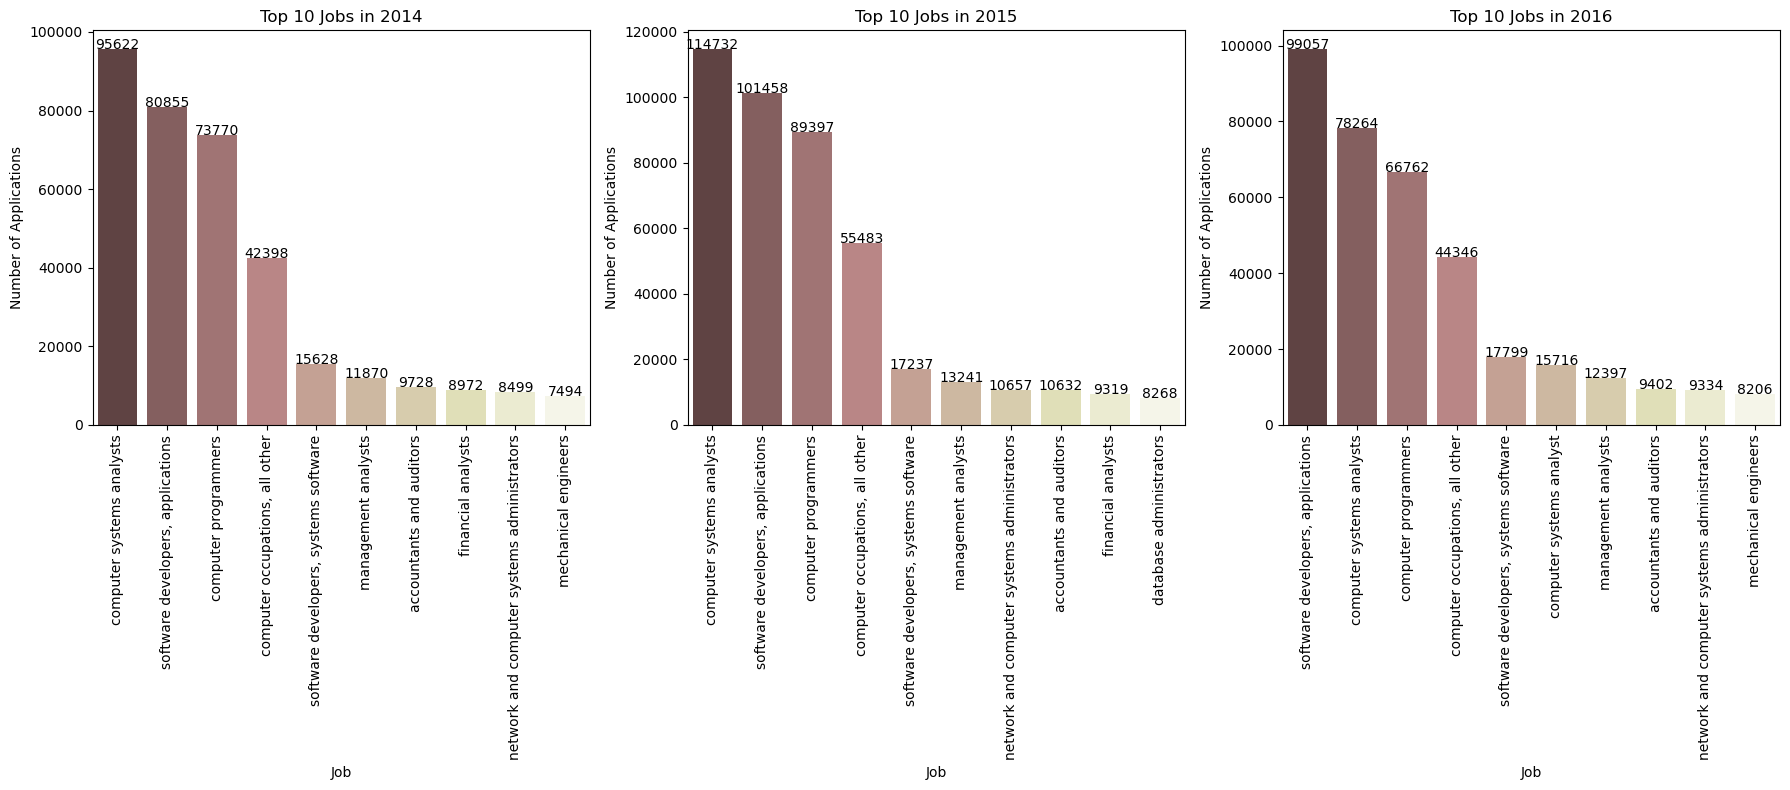

In [110]:
years = [2014, 2015, 2016]

fig, axs = plt.subplots(1, 3, figsize=(18, 8))

for i, year in enumerate(years):
    year_data = df_sample[df_sample['year'] == year]
    top_10_jobs = year_data['soc_name'].value_counts().nlargest(10)

    ax = sns.barplot(x=top_10_jobs.index, y=top_10_jobs.values, palette='pink', ax=axs[i])
    ax.set_xticklabels(top_10_jobs.index, rotation=90)
    ax.set_xlabel("Job")
    ax.set_ylabel("Number of Applications")
    ax.set_title(f"Top 10 Jobs in {year}")

    for index, value in enumerate(top_10_jobs.values):
        ax.text(index, value+0.5, str(value), ha='center')

plt.tight_layout()
plt.show()

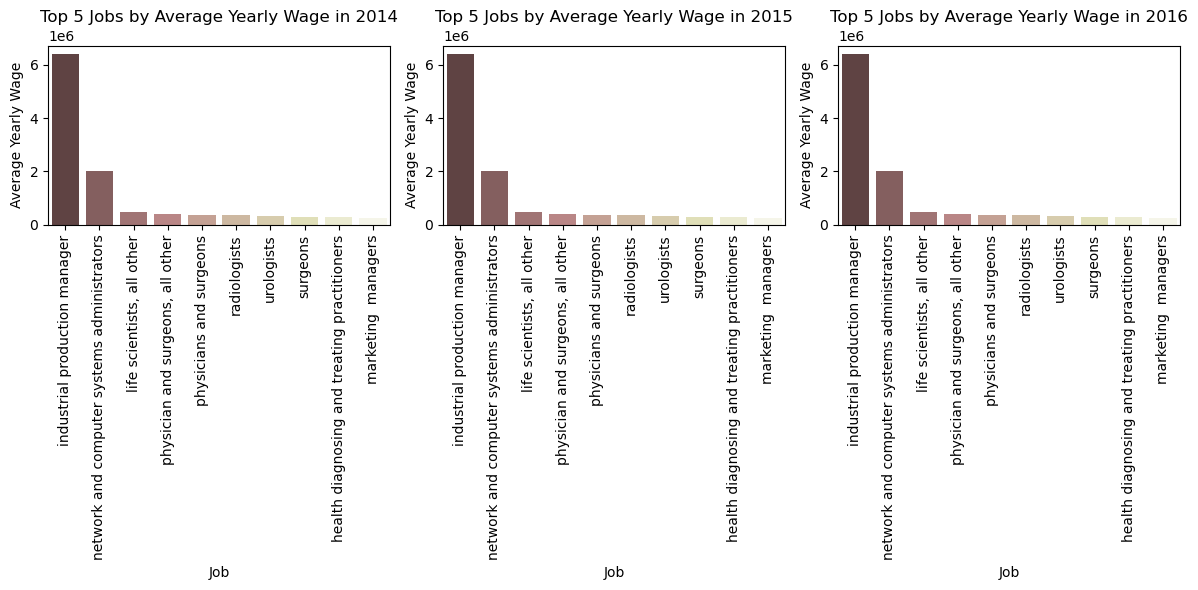

In [113]:
years = [2014, 2015, 2016]

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

for i, year in enumerate(years):
    year_data = df_yearly[df_yearly['year'] == year]
    top_10_avg_wages = df_yearly.groupby('soc_name')['calculated_wage'].mean().nlargest(10)
    
    ax = sns.barplot(x=top_10_avg_wages.index, y=top_10_avg_wages.values, palette='pink', ax=axes[i])
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
    axes[i].set_xlabel("Job")
    axes[i].set_ylabel("Average Yearly Wage")
    axes[i].set_title(f"Top 5 Jobs by Average Yearly Wage in {year}")
    
    
plt.tight_layout()
plt.show()

Although copywriter is the occupation with the highest hourly wage, it is not representative as there are only two petitions filed for this occupation in total.

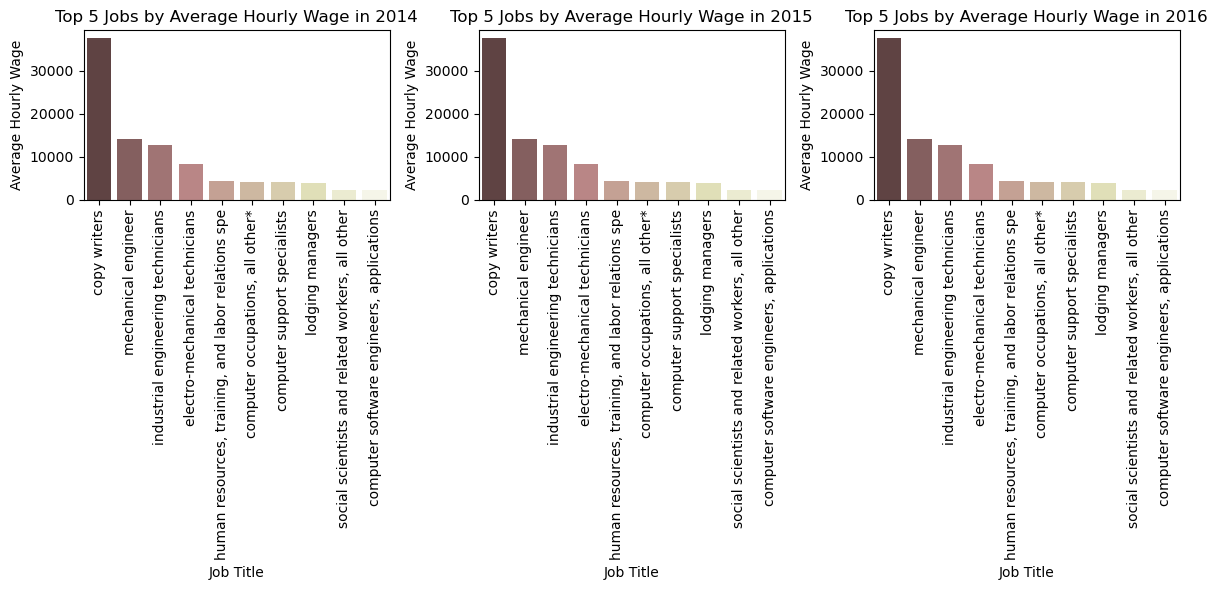

In [83]:
years = [2014, 2015, 2016]

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

for i, year in enumerate(years):
    year_data = df_hourly[df_hourly['year'] == year]
    top_10_avg_wages = df_hourly.groupby('soc_name')['calculated_wage'].mean().nlargest(10)
    
    ax = sns.barplot(x=top_10_avg_wages.index, y=top_10_avg_wages.values, palette='pink', ax=axes[i])
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
    axes[i].set_xlabel("Job Title")
    axes[i].set_ylabel("Average Hourly Wage")
    axes[i].set_title(f"Top 5 Jobs by Average Hourly Wage in {year}")

    
plt.tight_layout()
plt.show()

In [140]:
df_hourly[df_hourly['soc_name'] == 'copy writers'].describe()

wage_rate_of_pay_from  wage_rate_of_pay_to  total_workers  \
count                   1.00                 0.00           1.00   
mean                75000.00                  NaN           1.00   
std                      NaN                  NaN            NaN   
min                 75000.00                  NaN           1.00   
25%                 75000.00                  NaN           1.00   
50%                 75000.00                  NaN           1.00   
75%                 75000.00                  NaN           1.00   
max                 75000.00                  NaN           1.00   

       prevailing_wage  pw_source_year  naic_code  total workers  \
count             2.00            1.00       2.00           1.00   
mean          27819.82         2013.00  631460.00           1.00   
std           39313.98             NaN  126784.25            NaN   
min              20.64         2013.00  541810.00           1.00   
25%           13920.23         2013.00  586635.00           1.00   
50%           27819.82         2013.00  631460.00           1.00   
75%           41719.41         2013.00  676285.00           1.00   
max           55619.00         2013.00  721110.00           1.00   

       pw_wage_source_year  calculated_wage    year  
count                 1.00             2.00    2.00  
mean               2014.00         37510.32 2014.50  
std                    NaN         53018.41    0.71  
min                2014.00            20.64 2014.00  
25%                2014.00         18765.48 2014.25  
50%                2014.00         37510.32 2014.50  
75%                2014.00         56255.16 2014.75  
max                2014.00         75000.00 2015.00

#### 3.3.2 What is the number of successful and failed applications for each job?

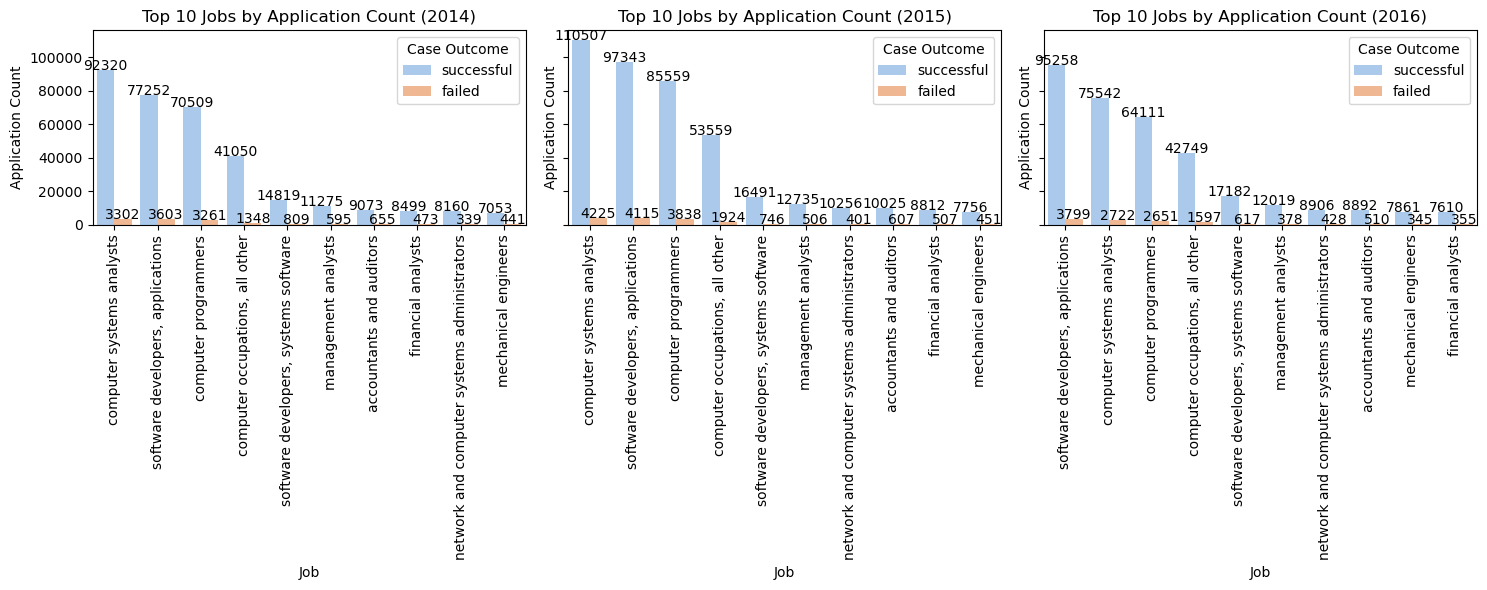

In [79]:
years = [2014, 2015, 2016]

# Calculate total applications and successful applications for each job title by year
job_yearly_data = df_sample.groupby(['year', 'soc_name', 'case_outcome']).agg({'successful_petition': 'count'}).reset_index()
job_yearly_data.columns = ['year', 'soc_name', 'case_outcome', 'application_count']

# Find top 10 job titles by total applications
top_10_jobs = job_yearly_data.groupby('soc_name')['application_count'].sum().nlargest(10).index

# Filter data for top 10 job titles
top_10_job_data = job_yearly_data[job_yearly_data['soc_name'].isin(top_10_jobs)].copy()

# Reorder job titles by total applications
top_10_job_data['job_title'] = pd.Categorical(top_10_job_data['soc_name'], categories=top_10_jobs, ordered=True)

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

for idx, year in enumerate(years):
    data_year = top_10_job_data[top_10_job_data['year'] == year]
    data_year = data_year.sort_values(by='application_count', ascending=False)

    ax = sns.barplot(data=data_year, x='soc_name', y='application_count', hue='case_outcome',hue_order=['successful', 'failed'], errorbar=None, ax=axes[idx], palette='pastel')
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=90)
    axes[idx].set_xlabel("Job")
    axes[idx].set_ylabel("Application Count")
    axes[idx].set_title(f"Top 10 Jobs by Application Count ({year})")
    axes[idx].legend(title='Case Outcome', loc='upper right')
    
    # Add the application counts as annotations
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.tight_layout()
plt.show()

#### 3.3.3 What are the top 10 states/cities in terms of number of petitions filed and top 10 jobs in terms of count of petitions filed?

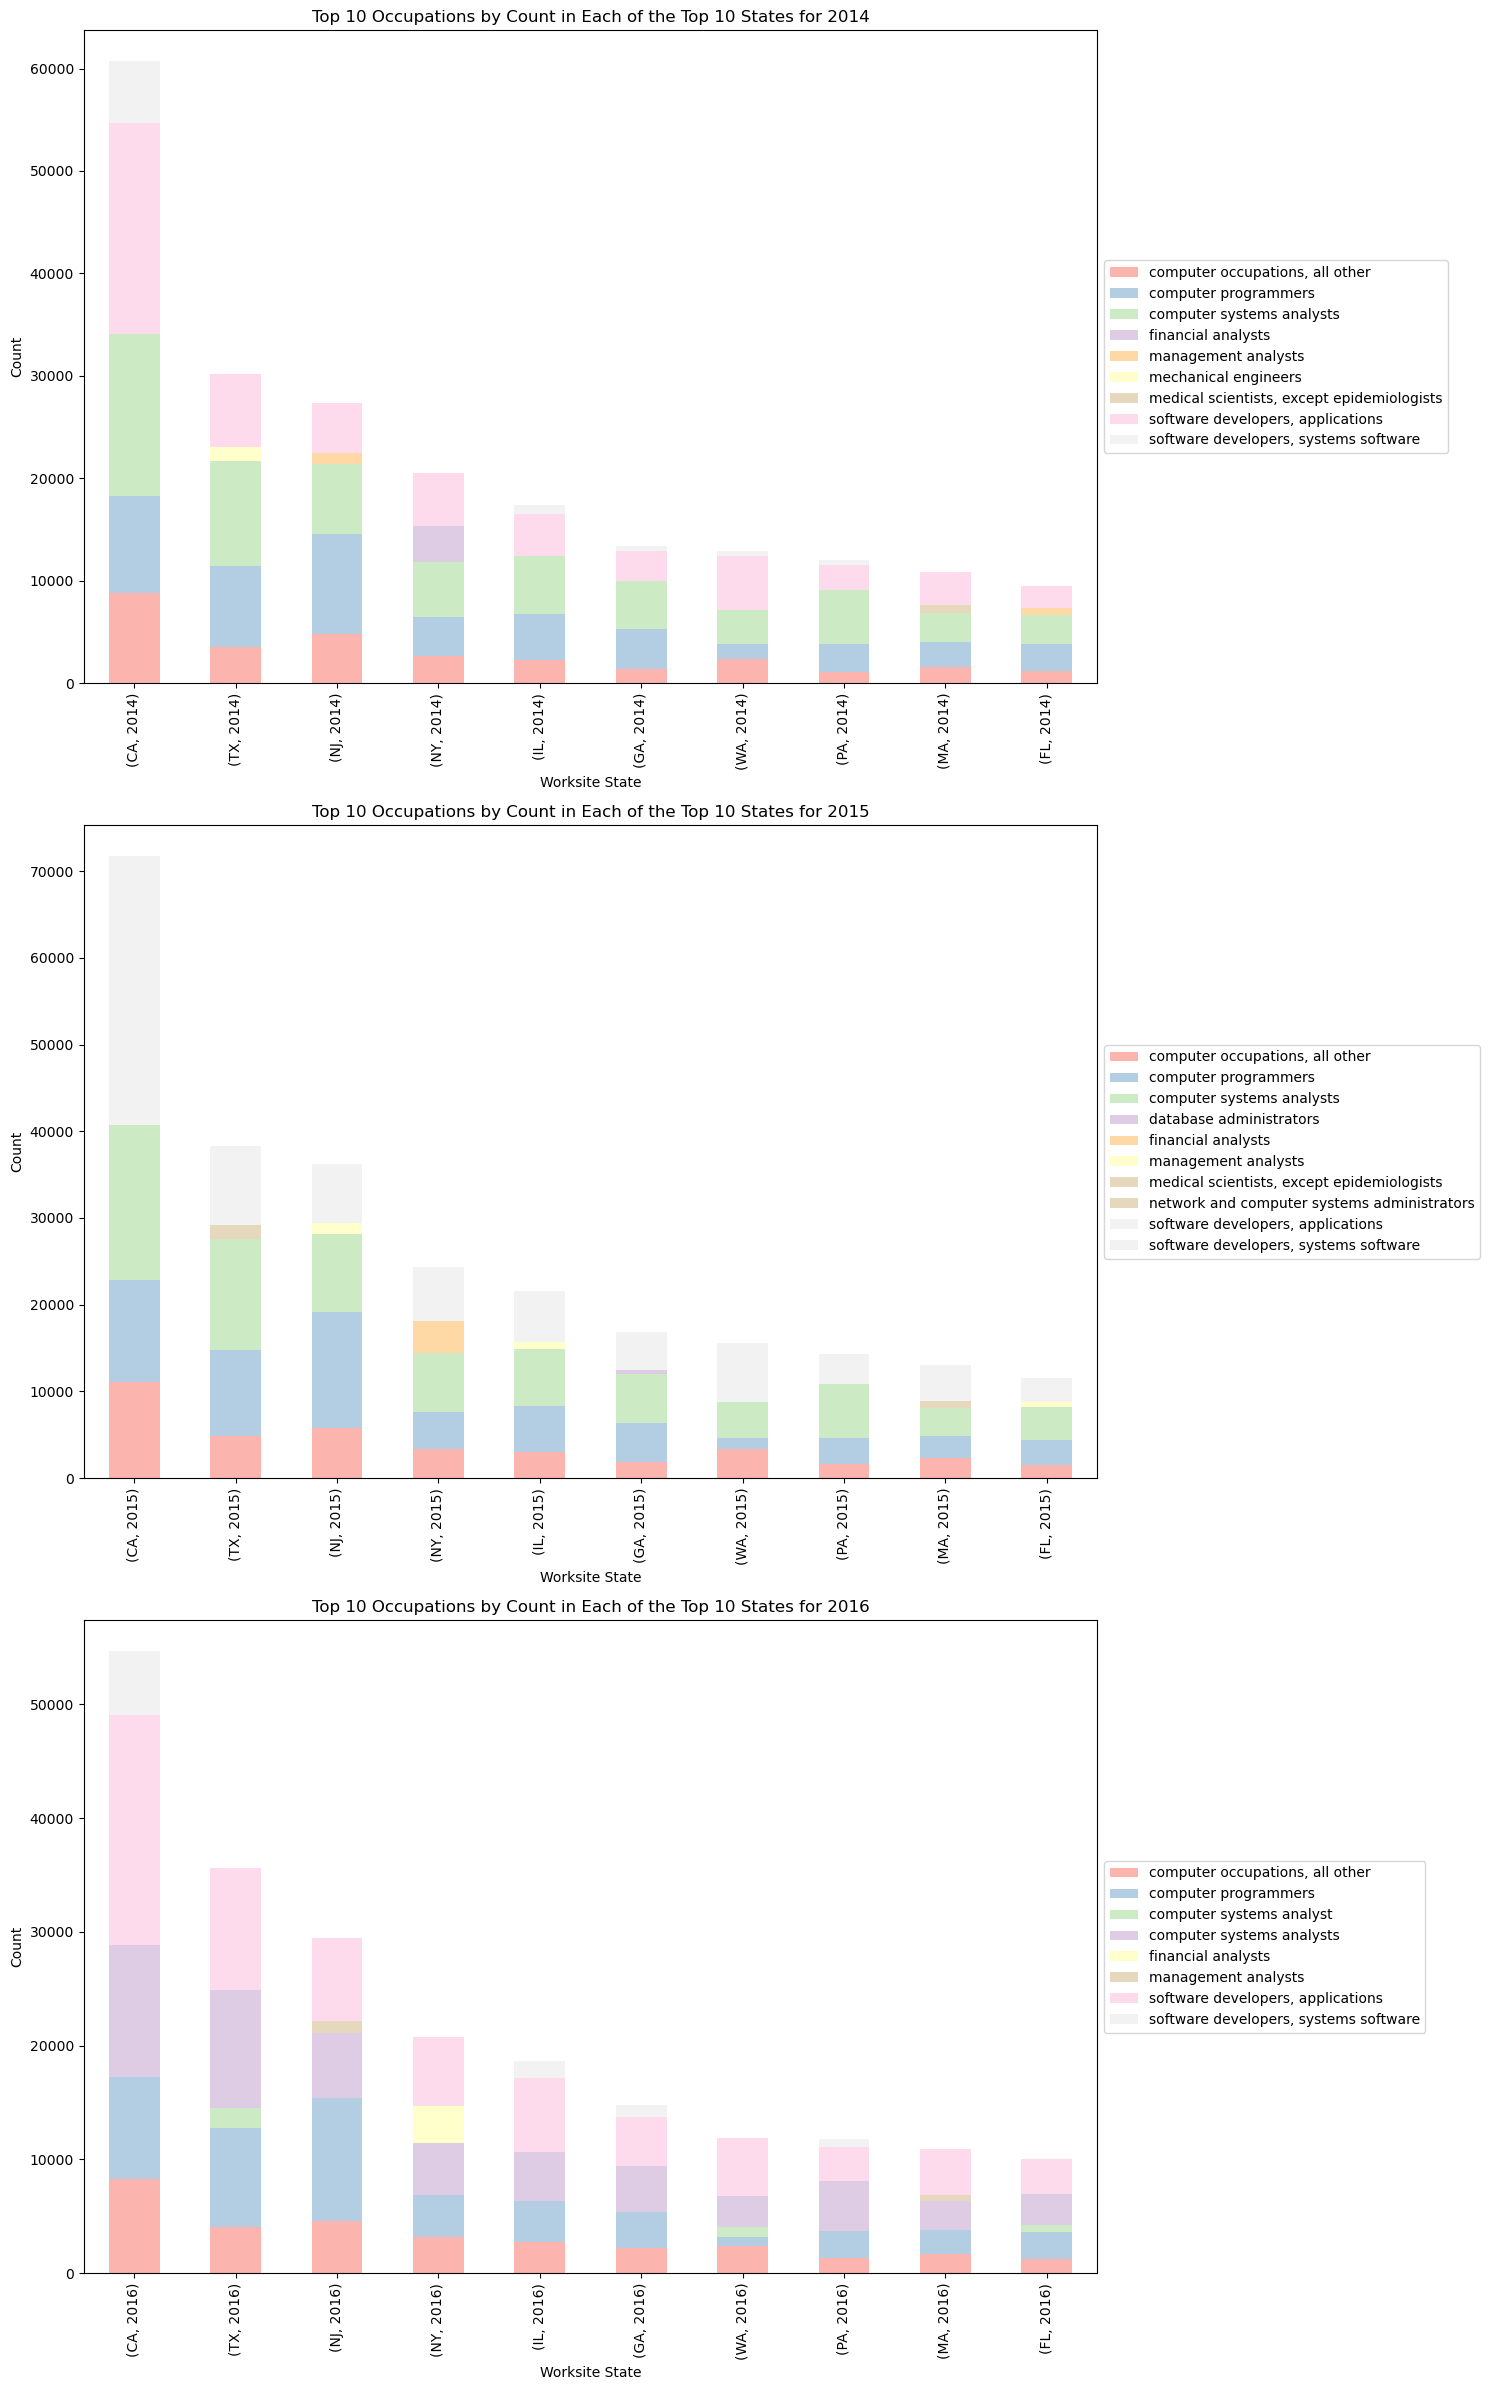

In [163]:
# Group the data by worksite_state and year
grouped_by_state = df_filtered.groupby(['worksite_state', 'year'])

# Calculate the total applications for each state
total_applications_by_state = df_filtered.groupby('worksite_state')['case_number'].count().reset_index(name='total_applications')

# Get the top 10 states by total applications
top_10_states = total_applications_by_state.sort_values('total_applications', ascending=False).head(10)['worksite_state'].values

# Filter the data for the top 10 states
df_filtered_top_states = df_filtered[df_filtered['worksite_state'].isin(top_10_states)]

# Group the filtered data by state and year
grouped_data = df_filtered_top_states.groupby(['worksite_state', 'year'])

# Initialize an empty list to store the top 10 occupations for each group
top_occupations_list = []

# Iterate over the groups and find the top 10 occupations
for (group, year), group_data in grouped_data:
    top_occupations = group_data['soc_name'].value_counts().head(5)
    top_occupations_list.append(pd.DataFrame({'group': group, 'year': year, 'occupation': top_occupations.index, 'count': top_occupations.values}))

# Concatenate the list of DataFrames into a single DataFrame
top_occupations_df = pd.concat(top_occupations_list, ignore_index=True)

# Plot the stacked bar chart for each year
years = [2014, 2015, 2016]
fig, ax = plt.subplots(3, 1, figsize=(15, 24))

for i, year in enumerate(years):
    pivot_df = top_occupations_df[top_occupations_df['year'] == year].pivot_table(index=['group', 'year'], columns='occupation', values='count', fill_value=0)
    pivot_df['total'] = pivot_df.sum(axis=1)
    pivot_df = pivot_df.sort_values('total', ascending=False).drop('total', axis=1)
    
    bar_plot = pivot_df.plot(kind='bar', stacked=True, ax=ax[i], colormap='Pastel1')
    
    ax[i].set_xlabel('Worksite State')
    ax[i].set_ylabel('Count')
    ax[i].set_title(f'Top 10 Occupations by Count in Each of the Top 10 States for {year}')
    ax[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

#### 3.3.4 Results

The occupations with the highest number of applications and the highest annual salaries are both related to computer science and information technology.

### 3.4 Wages

#### 3.4.1 Is the applicant wage correlated with petition success?   

In this section, I grouped the salary level by annual salary and hourly wage separately, and used logistic regression to calculate the correlation between different salary levels and successful petition outcomes. The results showed that there was no significant correlation between the two. Therefore, I combined other external data to explore whether there is a correlation between salary and successful petitions under different groups.

*Section 3.4.1 is for displaying the analysis process only and does not need to be executed. You can skip directly to section 3.5.

#### 3.4.1 Is the applicant wage correlated with petition success?   

##### a. yearly-wages

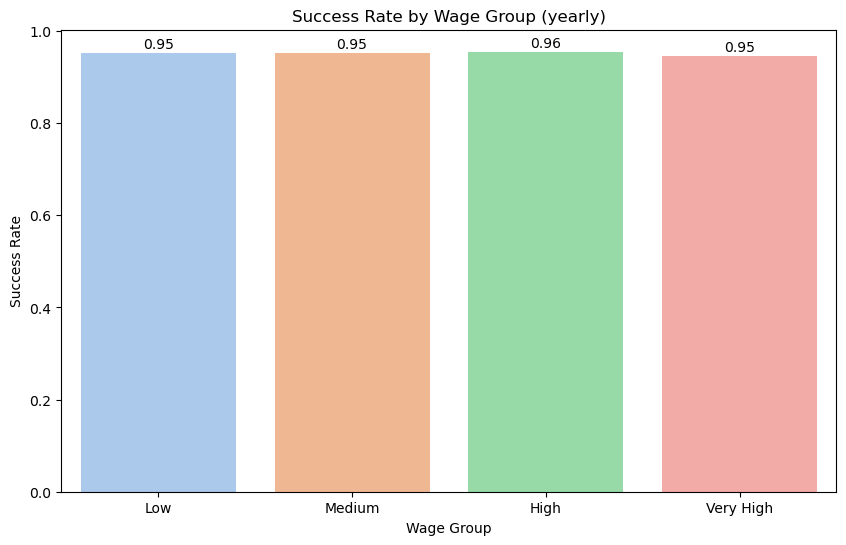

In [72]:
df_yearly_copy = df_yearly.copy()

df_yearly_copy['successful_petition'] = np.where(df_yearly_copy['case_status'].isin(['certified', 'certified-withdrawn']), 1, 0)

# set groups
wage_bins = [30000, 80000, 100000, 150000, np.inf]  
wage_labels = ['Low', 'Medium', 'High', 'Very High']
df_yearly_copy['wage_group'] = pd.cut(df_yearly_copy['calculated_wage'], bins=wage_bins, labels=wage_labels)

# calculate certified rate
grouped_data = df_yearly_copy.groupby('wage_group')['successful_petition'].mean().reset_index()

# Handle non-finite values
grouped_data['successful_petition'] = grouped_data['successful_petition'].fillna(0)

# visualise 
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=grouped_data, x='wage_group', y='successful_petition', palette='pastel')
plt.xlabel("Wage Group")
plt.ylabel("Success Rate")
plt.title("Success Rate by Wage Group (yearly)")

for index, row in grouped_data.iterrows():
    ax.text(index, row['successful_petition'] + 0.01, round(row['successful_petition'], 2), color='black', ha='center')

plt.show()

Logistical regression

In [74]:
df_yearly_copy = df_yearly_copy.dropna(subset=['calculated_wage'])

X = df_yearly_copy[['calculated_wage']]
y = df_yearly_copy['successful_petition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# predict
y_pred = log_reg.predict(X_test)

# report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9526622608640062
ROC AUC Score: 0.5


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     23695
           1       0.95      1.00      0.98    476857

    accuracy                           0.95    500552
   macro avg       0.48      0.50      0.49    500552
weighted avg       0.91      0.95      0.93    500552



C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



##### b. hourly wages

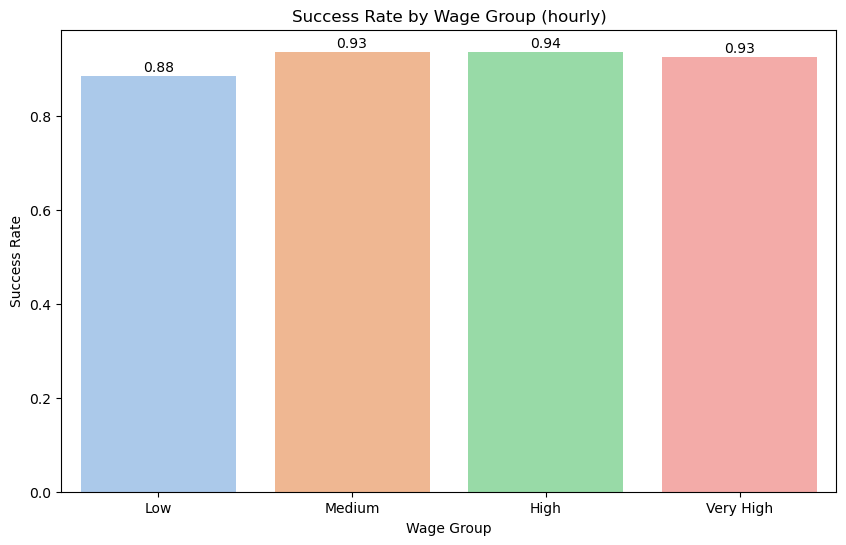

In [76]:
df_hourly_copy = df_hourly.copy()

df_hourly_copy['successful_petition'] = np.where(df_hourly_copy['case_status'].isin(['certified', 'certified-withdrawn']), 1, 0)

# set groups
wage_bins = [0, 27.5, 32.14, 39.575, np.inf]  
wage_labels = ['Low', 'Medium', 'High', 'Very High']
df_hourly_copy['wage_group'] = pd.cut(df_hourly_copy['calculated_wage'], bins=wage_bins, labels=wage_labels)

# calculate certified rate
grouped_data = df_hourly_copy.groupby('wage_group')['successful_petition'].mean().reset_index()

# visualise 
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=grouped_data, x='wage_group', y='successful_petition', palette='pastel')
plt.xlabel("Wage Group")
plt.ylabel("Success Rate")
plt.title("Success Rate by Wage Group (hourly)")

for index, row in grouped_data.iterrows():
    ax.text(index, row['successful_petition'] + 0.01, round(row['successful_petition'], 2), color='black', ha='center')

plt.show()

In [77]:
X = df_hourly_copy[['calculated_wage']]
y = df_hourly_copy['successful_petition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9191433566433567
ROC AUC Score: 0.5135655921217437
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.03      0.05      2829
           1       0.92      1.00      0.96     31491

    accuracy                           0.92     34320
   macro avg       0.84      0.51      0.51     34320
weighted avg       0.91      0.92      0.88     34320



### 3.5 Bonus
#### 3.5.1 Merge extra data

Add more data columns from other data sources to augment your analysis.

'''
    The Standard Occupational Classification (SOC) Code system in the United States is classified according to a certain hierarchical structure. The SOC system consists of five levels, from highest to lowest:

        Major group
        Minor group
        Broad occupation
        Detailed occupation
        Specific occupation
The Major group is the highest level, which includes 23 categories. Each category has a two-digit code. The Minor group is the next level, which includes 96 subcategories. Each subcategory has a three-digit code. Broad occupation is the third level, which includes 459 occupational categories. Each occupational category has a four-digit code. Detailed occupation is the fourth level, which includes 839 occupational categories. Each occupational category has a five-digit code. Specific occupation is the smallest level, which includes 1305 occupational categories. Each occupational category has a six-digit code.
'''

Source: https://www.bls.gov/soc/2018/soc_2018_class_and_coding_structure.pdf
   

   
Here we use major group to aggregate our data:

In [154]:
occupations = {
    '11-0000': 'Management Occupations',
    '13-0000': 'Business and Financial Operations Occupations',
    '15-0000': 'Computer and Mathematical Occupations',
    '17-0000': 'Architecture and Engineering Occupations',
    '19-0000': 'Life, Physical, and Social Science Occupations',
    '21-0000': 'Community and Social Service Occupations',
    '23-0000': 'Legal Occupations',
    '25-0000': 'Education, Training, and Library Occupations',
    '27-0000': 'Arts, Design, Entertainment, Sports, and Media Occupations',
    '29-0000': 'Healthcare Practitioners and Technical Occupations',
    '31-0000': 'Healthcare Support Occupations',
    '33-0000': 'Protective Service Occupations',
    '35-0000': 'Food Preparation and Serving Related Occupations',
    '37-0000': 'Building and Grounds Cleaning and Maintenance Occupations',
    '39-0000': 'Personal Care and Service Occupations',
    '41-0000': 'Sales and Related Occupations',
    '43-0000': 'Office and Administrative Support Occupations',
    '45-0000': 'Farming, Fishing, and Forestry Occupations',
    '47-0000': 'Construction and Extraction Occupations',
    '49-0000': 'Installation, Maintenance, and Repair Occupations',
    '51-0000': 'Production Occupations',
    '53-0000': 'Transportation and Material Moving Occupations',
    '55-0000': 'Military Specific Occupations'
}

# dictionary transfers to DataFrame
df_occupations = pd.DataFrame(list(occupations.items()), columns=['soc_code_major', 'occupation'])

print(df_occupations)

   soc_code_major                                         occupation
0         11-0000                             Management Occupations
1         13-0000      Business and Financial Operations Occupations
2         15-0000              Computer and Mathematical Occupations
3         17-0000           Architecture and Engineering Occupations
4         19-0000     Life, Physical, and Social Science Occupations
5         21-0000           Community and Social Service Occupations
6         23-0000                                  Legal Occupations
7         25-0000       Education, Training, and Library Occupations
8         27-0000  Arts, Design, Entertainment, Sports, and Media...
9         29-0000  Healthcare Practitioners and Technical Occupat...
10        31-0000                     Healthcare Support Occupations
11        33-0000                     Protective Service Occupations
12        35-0000   Food Preparation and Serving Related Occupations
13        37-0000  Building and Gr

In [155]:
df_sample['soc_code_major'] = df_sample['soc_code'].str[:2]
df_yearly['soc_code_major'] = df_yearly['soc_code'].str[:2]
df_hourly['soc_code_major'] = df_hourly['soc_code'].str[:2]

df_occupations['soc_code_major'] = df_occupations['soc_code_major'].str[:2]

df_sample = pd.merge(df_sample, df_occupations, on='soc_code_major', how='left')
df_yearly = pd.merge(df_yearly, df_occupations, on='soc_code_major', how='left')
df_hourly = pd.merge(df_hourly, df_occupations, on='soc_code_major', how='left')

In [156]:
df_yearly['successful_petition'] = np.where(df_yearly['case_status'].isin(['certified', 'certified-withdrawn']), 1, 0)
df_hourly['successful_petition'] = np.where(df_hourly['case_status'].isin(['certified', 'certified-withdrawn']), 1, 0)

#### 3.5.2 distribution of the number of petitions by occupations

In [168]:
value_counts = df_sample['occupation'].value_counts()
print(value_counts.head(10))

Computer and Mathematical Occupations                         1212963
Business and Financial Operations Occupations                  154174
Architecture and Engineering Occupations                       120252
Life, Physical, and Social Science Occupations                  68399
Management Occupations                                          65470
Healthcare Practitioners and Technical Occupations              63495
Education, Training, and Library Occupations                    46846
Arts, Design, Entertainment, Sports, and Media Occupations      30909
Sales and Related Occupations                                    9048
Legal Occupations                                                6338
Name: occupation, dtype: int64


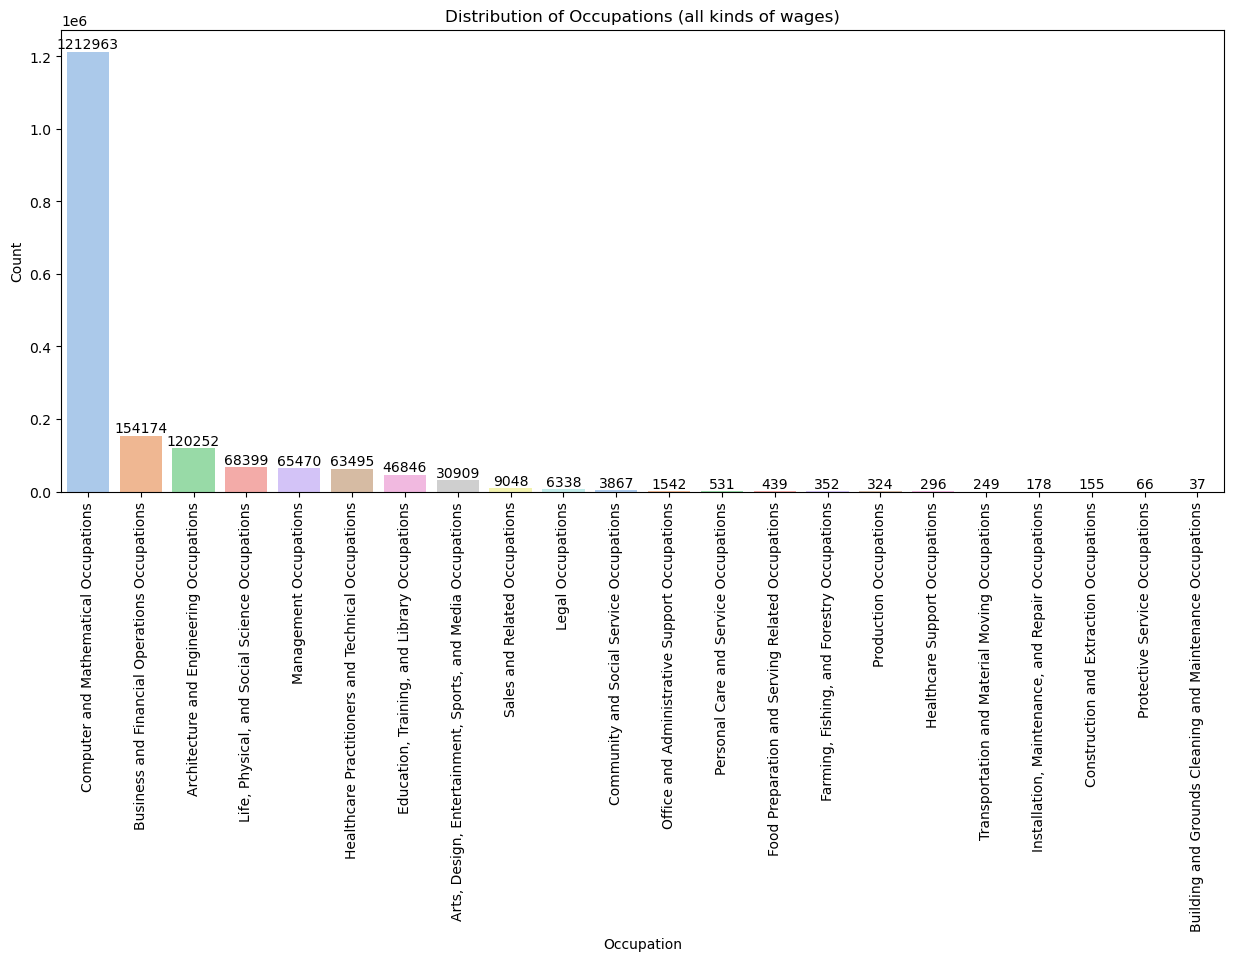

In [169]:
plt.figure(figsize=(15,6))
sns.countplot(data=df_sample, x='occupation', palette='pastel', order=value_counts.index)
plt.xticks(rotation=90)
plt.xlabel("Occupation")
plt.ylabel("Count")
plt.title("Distribution of Occupations (all kinds of wages)")

for i, v in enumerate(value_counts.values):
    plt.annotate(str(v), xy=(i, v), ha='center', va='bottom')
    
plt.show()

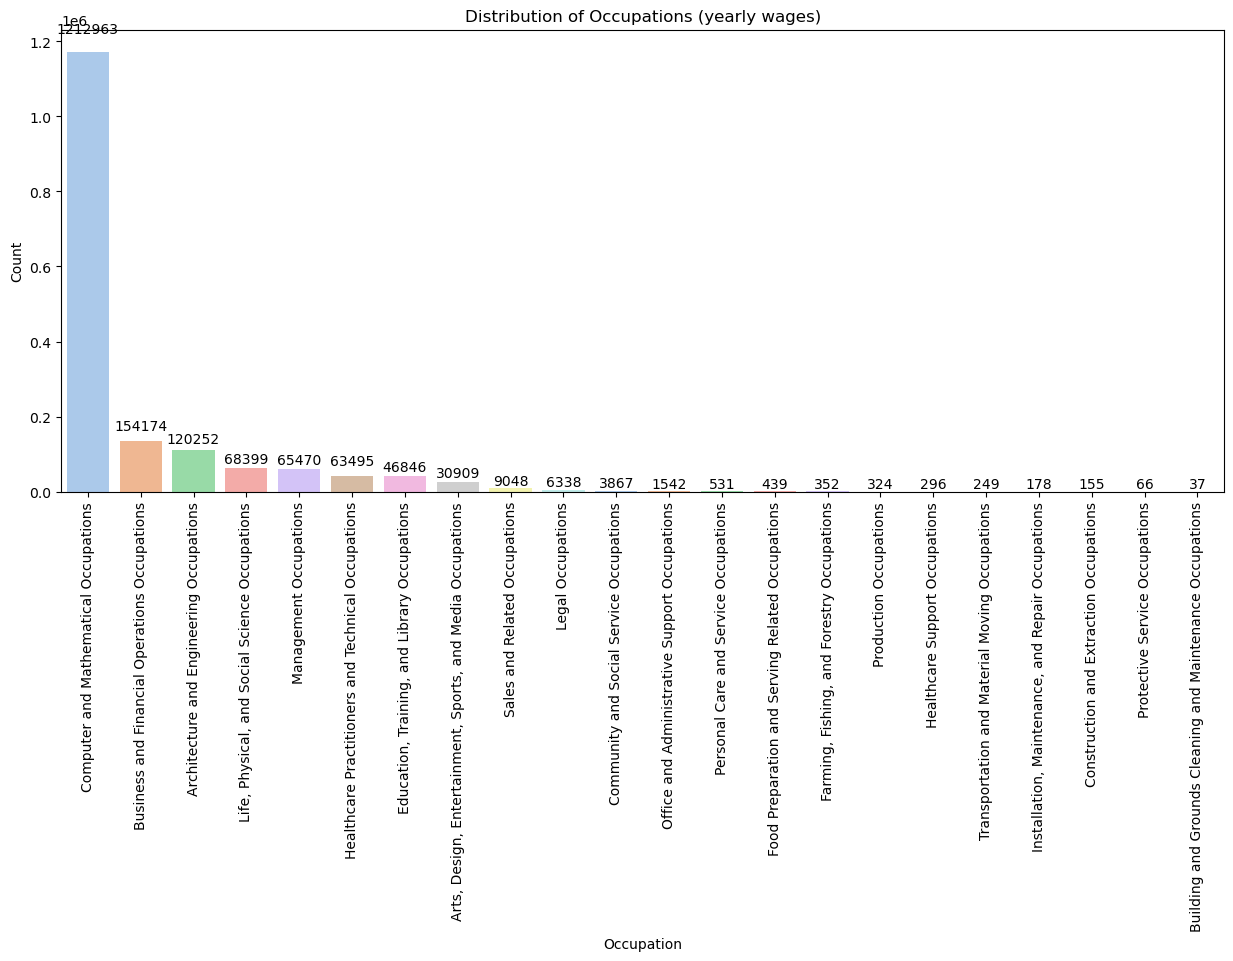

In [170]:
plt.figure(figsize=(15,6))
sns.countplot(data=df_yearly, x='occupation', palette='pastel', order=value_counts.index)
plt.xticks(rotation=90)
plt.xlabel("Occupation")
plt.ylabel("Count")
plt.title("Distribution of Occupations (yearly wages)")

for i, v in enumerate(value_counts.values):
    plt.annotate(str(v), xy=(i, v), ha='center', va='bottom')
    
plt.show()

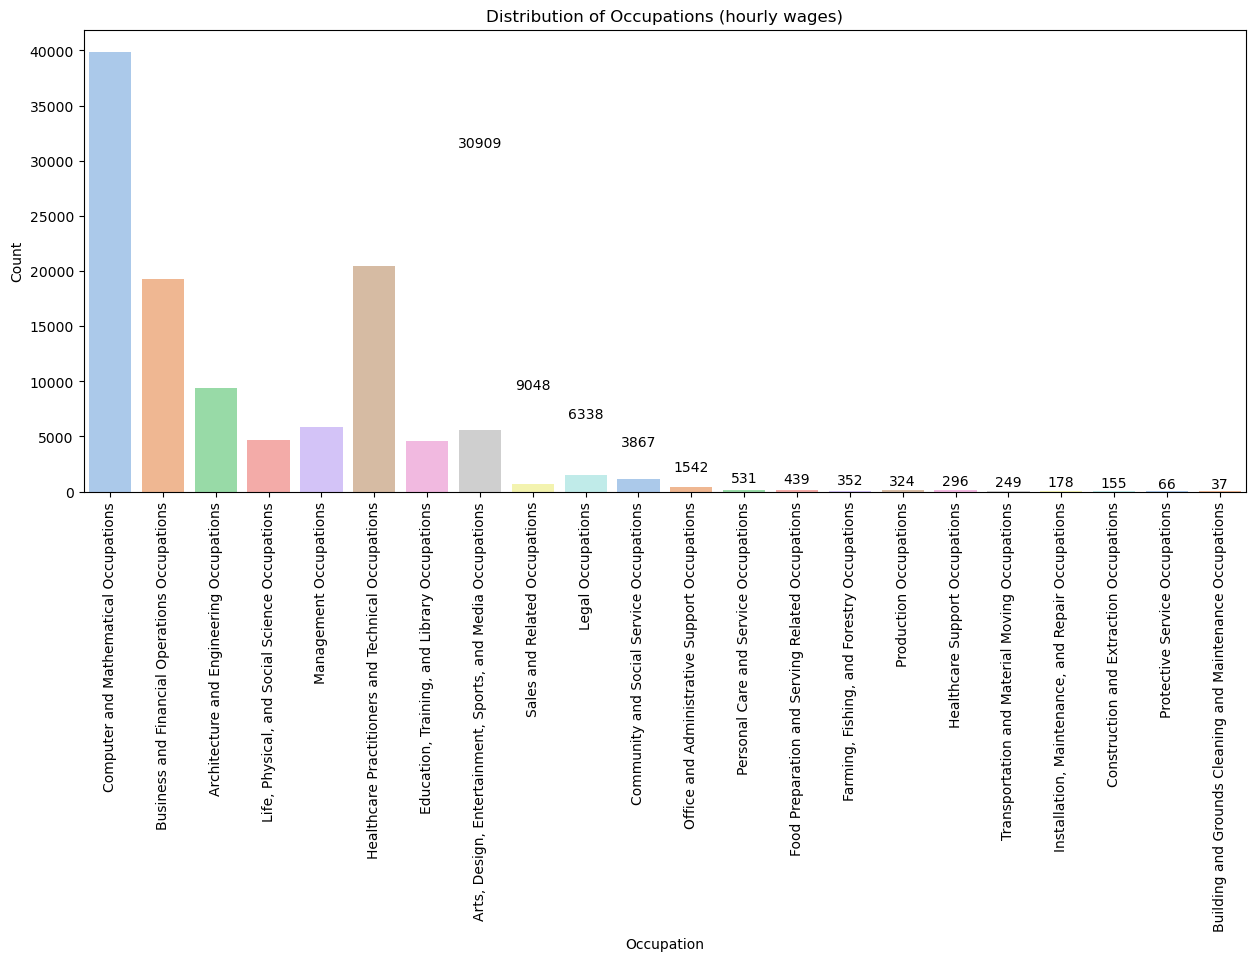

In [ ]:
plt.figure(figsize=(15,6))
sns.countplot(data=df_hourly, x='occupation', palette='pastel', order=value_counts.index)
plt.xticks(rotation=90)
plt.xlabel("Occupation")
plt.ylabel("Count")
plt.title("Distribution of Occupations (hourly wages)")

for i, v in enumerate(value_counts.values):
    plt.annotate(str(v), xy=(i, v), ha='center', va='bottom')
    
plt.show()

#### 3.5.3 Is the applicant wage correlated with petition success? （again）

Considering that the selection process of H-1B visas is not a random one, requiring applicants to have a salary that meets or exceeds the market rate and is equal to or higher than that of local employees (source: https://www.govinfo.gov/content/pkg/USCODE-2016-title8/html/USCODE-2016-title8-chap12-subchapII-partII-sec1182.htm), we need to take into account whether the salary of these applicants (which has already been recalculated and stored in the 'calculated_wage' field in our dataset) exceeds the prevailing wage in their industry, and whether having a salary higher or lower than the prevailing wage really affects their chances of successfully obtaining a visa.

##### a. distribution of prevailing wages in different occupations

C:\Users\StevenYang\AppData\Local\Temp\ipykernel_54740\4028296069.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



                                              soc_name  wage_difference
0                                           13-2011.01             1.00
1                                              15-1121             1.00
2                                              15-1132             1.00
3                                           15-1199.01             1.00
4     15-1199.01 sw quality assurance engnrs & testers             1.00
...                                                ...              ...
1393                             wind energy engineers             1.00
1394                  wind turbine service technicians             1.00
1395                            woodworkers, all other             1.00
1396                               writers and authors             0.99
1397                zoologists and wildlife biologists             0.98

[1398 rows x 2 columns]
                                           occupation pw_wage_level  count
0            Architecture and Engine

C:\Users\StevenYang\AppData\Local\Temp\ipykernel_54740\4028296069.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



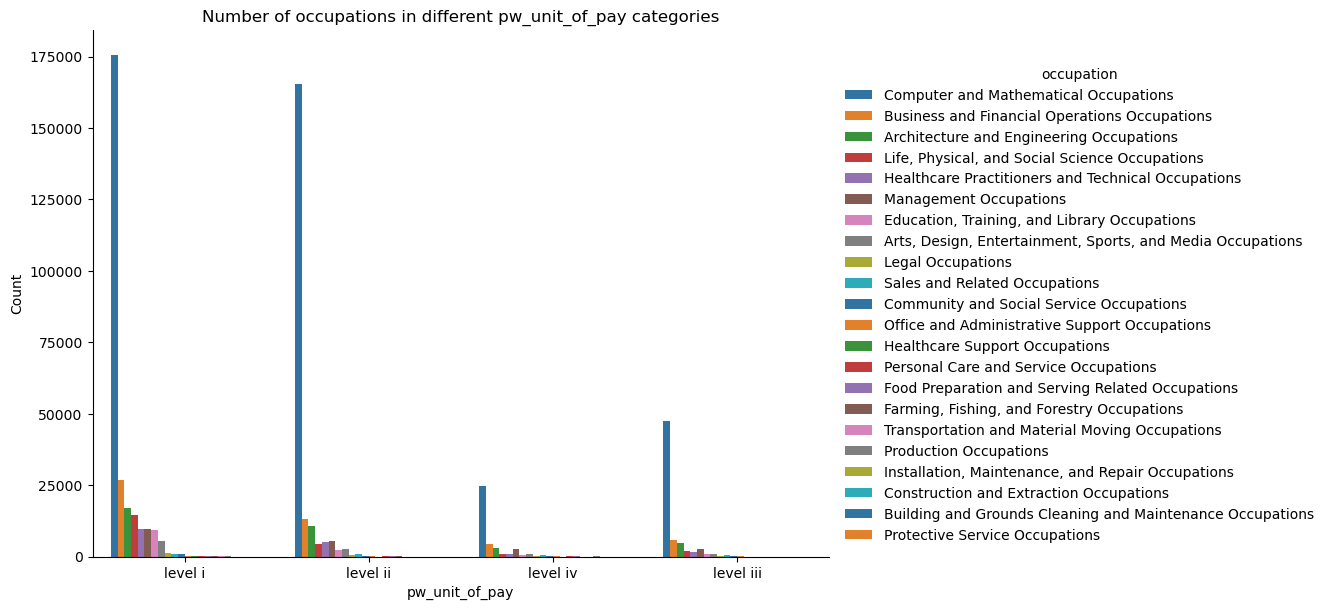

In [205]:
# Step 1: Filter rows where prevailing_wage is not null
df_filtered = df_sample[df_sample['prevailing_wage'].notnull()]

# Step 2: Compare average calculated_wage with prevailing_wage by occupation
df_filtered['wage_difference'] = df_filtered['calculated_wage'] >= df_filtered['prevailing_wage']
avg_wage_diff_by_occupation = df_filtered.groupby('soc_name')['wage_difference'].mean().reset_index()
print(avg_wage_diff_by_occupation)

# Step 3: Calculate the count of each occupation in different pw_unit_of_pay categories
occupation_counts_by_pay_unit = df_filtered.groupby(['occupation', 'pw_wage_level']).size().reset_index(name='count')
print(occupation_counts_by_pay_unit)

# Group by pw_wage_level and occupation, then sort by count
grouped_data = df_filtered.groupby(['pw_wage_level', 'occupation']).size().reset_index(name='count')
grouped_data_sorted = grouped_data.sort_values(['pw_wage_level', 'count'], ascending=[True, False])

# Reorder the occupation column based on the sorted data
sorted_occupations = grouped_data_sorted['occupation'].unique()
df_filtered['occupation'] = pd.Categorical(df_filtered['occupation'], categories=sorted_occupations, ordered=True)

# Plot the chart with the reordered occupation column
sns.catplot(data=df_filtered, x='pw_wage_level', hue='occupation', kind='count', height=6, aspect=1.5, palette='tab10', dodge=0.5)
plt.title("Number of occupations in different pw_unit_of_pay categories")
plt.xlabel("pw_unit_of_pay")
plt.ylabel("Count")
plt.show()

##### b. correlation between calculated_wage and successful_petition in two different situations

Group 1 (calculated_wage >= prevailing_wage) counts:
   successful_petition    count
0                    0    84795
1                    1  1695681
Group 2 (calculated_wage < prevailing_wage) counts:
   successful_petition  count
0                    0   4570
1                    1    858
Spearman correlation between calculated_wage and successful_petition for Group 1: 0.02685603425718595
Spearman correlation between calculated_wage and successful_petition for Group 2: -0.4254510179273773


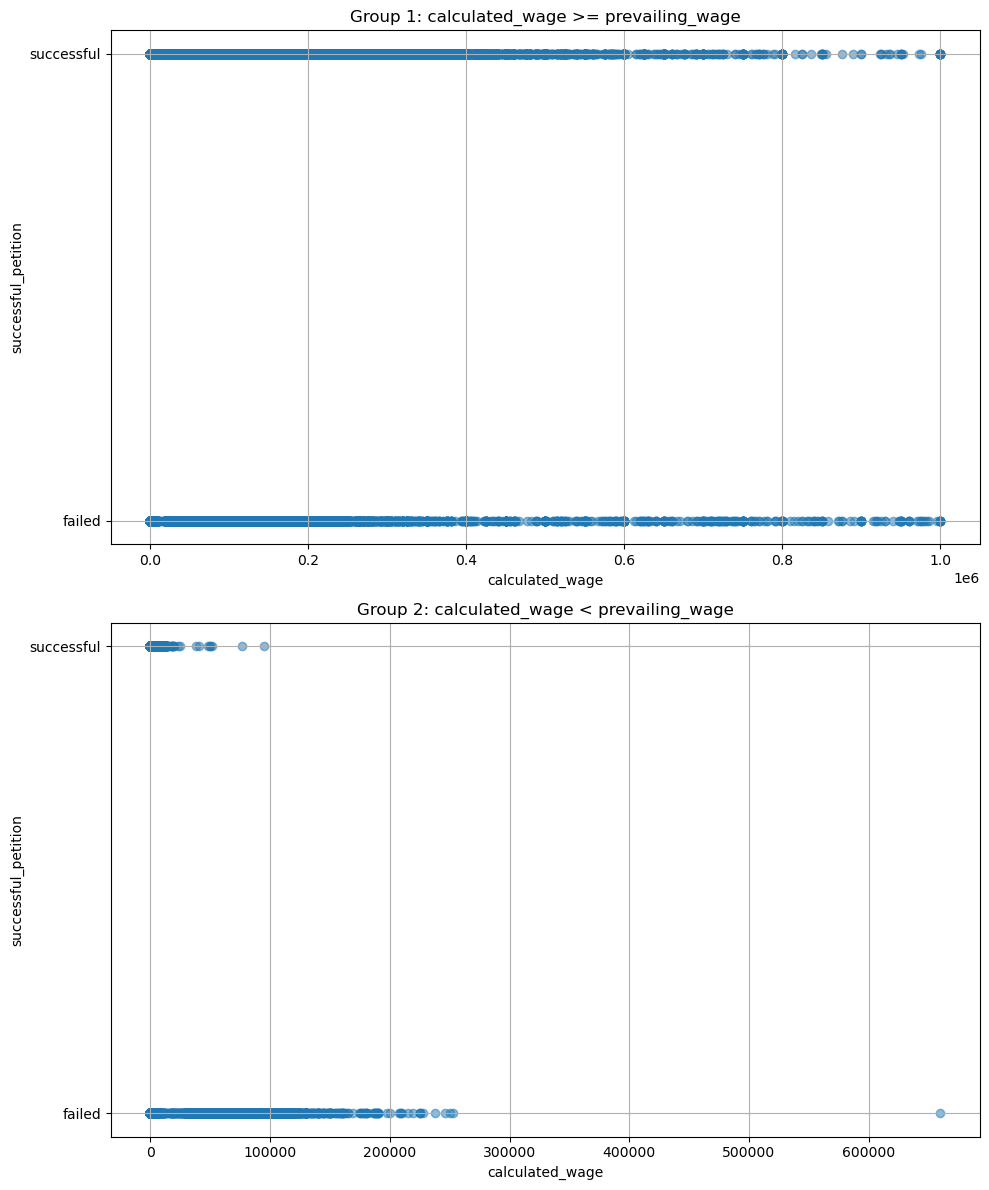

In [207]:
# Split the data into two groups based on the comparison of calculated_wage and prevailing_wage
group1 = df_filtered[df_filtered['calculated_wage'] >= df_filtered['prevailing_wage']]
group2 = df_filtered[df_filtered['calculated_wage'] < df_filtered['prevailing_wage']]

# Calculate success and failure counts for both groups
group1_counts = group1.groupby('successful_petition').size().reset_index(name='count')
group2_counts = group2.groupby('successful_petition').size().reset_index(name='count')

print("Group 1 (calculated_wage >= prevailing_wage) counts:")
print(group1_counts)
print("Group 2 (calculated_wage < prevailing_wage) counts:")
print(group2_counts)

# Calculate the correlation between calculated_wage and successful_petition in both groups
correlation_group1_spearman = group1['calculated_wage'].corr(group1['successful_petition'], method='spearman')
correlation_group2_spearman = group2['calculated_wage'].corr(group2['successful_petition'], method='spearman')

print(f"Spearman correlation between calculated_wage and successful_petition for Group 1: {correlation_group1_spearman}")
print(f"Spearman correlation between calculated_wage and successful_petition for Group 2: {correlation_group2_spearman}")


fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plot for Group 1: calculated_wage >= prevailing_wage
axes[0].scatter(group1['calculated_wage'], group1['successful_petition'], alpha=0.5)
axes[0].set_title("Group 1: calculated_wage >= prevailing_wage")
axes[0].set_xlabel("calculated_wage")
axes[0].set_ylabel("successful_petition")
axes[0].set_yticks([0, 1])
axes[0].set_yticklabels(['failed', 'successful'])
axes[0].grid()

# Plot for Group 2: calculated_wage < prevailing_wage
axes[1].scatter(group2['calculated_wage'], group2['successful_petition'], alpha=0.5)
axes[1].set_title("Group 2: calculated_wage < prevailing_wage")
axes[1].set_xlabel("calculated_wage")
axes[1].set_ylabel("successful_petition")
axes[1].set_yticks([0, 1])
axes[1].set_yticklabels(['failed', 'successful'])
axes[1].grid()

plt.tight_layout()
plt.show()

#### 3.5.4 Results 

For Group 1 (calculated_wage >= prevailing_wage), the Spearman correlation coefficient is close to 0 (0.0269), which means there is no significant monotonic relationship between calculated_wage and successful_petition. In this case, we cannot conclude that there is a definite relationship between calculated wage and application success.

For Group 2 (calculated_wage < prevailing_wage), the Spearman correlation coefficient is -0.4255, indicating that there is a certain degree of negative correlation between these two variables. A negative correlation means that when calculated_wage is lower, the likelihood of application success is relatively smaller; and when calculated_wage is higher, the likelihood of application success is relatively greater. However, this negative correlation is not very strong, so we cannot assert that they have a strong relationship.

The results of these two groups show that in Group 1, there is no apparent monotonic relationship between calculated wage and application success, while in Group 2, there is a certain degree of negative correlation between calculated wage and application success. This may suggest that when calculated wages are below prevailing wages, the impact of wages on application success is more significant.